# Model Comparison - ArXiv QA Test Results

This notebook compares the performance of different models on the `vidore_arxivqa_test_subsampled` dataset by analyzing their evaluation metrics.

In [2]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pprint import pp
from IPython.display import display, Markdown, Latex

# Set the style for our plots
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

## Load the metrics files for all models

In [6]:
# Define the results directory
results_dir = "./results/normal/"

In [7]:
datasets = ["arxivqa", "docvqa", "tabfquad", "tatdqa"]

In [9]:
# Find all arxivqa_test_subsampled_metrics.json files
merged_metrics_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file == "merged_dataset_metrics.json":
            merged_metrics_files.append(os.path.join(root, file))

print(f"Found {len(merged_metrics_files)} model result files for dataset.")

Found 8 model result files for dataset.


In [10]:
merged_metrics_files

['./results/normal/blip2-flan-t5-xl/merged_dataset_metrics.json',
 './results/normal/blip_Salesforce_blip-vqa-base/merged_dataset_metrics.json',
 './results/normal/clip_openai_clip-vit-base-patch32/merged_dataset_metrics.json',
 './results/normal/jina-clip-v1_jinaai_jina-clip-v1/merged_dataset_metrics.json',
 './results/normal/llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf/merged_dataset_metrics.json',
 './results/normal/scan/merged_dataset_metrics.json',
 './results/normal/siglip_google_siglip-so400m-patch14-384/merged_dataset_metrics.json',
 './results/normal/vit_google_vit-base-patch16-224-in21k/merged_dataset_metrics.json']

In [11]:
def calculate_metric_means(metrics_dict):
    init = False
    key_num = len(metrics_dict)
    for dataset, metric_dict in metrics_dict.items():
        if not init:
            init = True
            all_metrics = metric_dict
            continue
        for metric, value in metric_dict.items():
            if value is None: continue
            all_metrics[metric] += value

    # print(all_metrics)
    for metric in all_metrics.keys():
        all_metrics[metric] /= key_num
    return all_metrics

In [12]:
# Function to extract model name from file path
def get_model_name(file_path):
    # Extract the model directory name
    parts = file_path.split('/')
    # model_dir = [p for p in parts if p != 'results' and dataset not in p][-1]
    return file_path.split('/')[-2]

# Load all the metrics into a dictionary
model_metrics = {}

for file_path in merged_metrics_files:
    model_name = get_model_name(file_path)
    
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # Extract the metrics we want to compare
    metrics = calculate_metric_means(data['metrics'])
    model_metrics[model_name] = metrics
    
print(f"Loaded metrics for {len(model_metrics)} models.")
print("Models:")
for model in model_metrics.keys():
    print(f"- {model}")

Loaded metrics for 8 models.
Models:
- blip2-flan-t5-xl
- blip_Salesforce_blip-vqa-base
- clip_openai_clip-vit-base-patch32
- jina-clip-v1_jinaai_jina-clip-v1
- llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf
- scan
- siglip_google_siglip-so400m-patch14-384
- vit_google_vit-base-patch16-224-in21k


## Extract and organize key metrics for comparison

In [13]:
# Define the metrics we want to compare
metric_types = ['ndcg', 'map', 'recall', 'precision']
k_values = [1, 3, 5, 10, 20, 50, 100]

# Create a pandas DataFrame to hold all metrics for easy comparison
all_metrics = []

for model_name, metrics in model_metrics.items():
    for metric_type in metric_types:
        for k in k_values:
            metric_key = f"{metric_type}_at_{k}"
            if metric_key in metrics:
                all_metrics.append({
                    'Model': model_name,
                    'Metric': metric_type,
                    'k': k,
                    'Value': metrics[metric_key]
                })

metrics_df = pd.DataFrame(all_metrics)
metrics_df.head(10)

,Model,Metric,k,Value
0,blip2-flan-t5-xl,ndcg,1,0.005753
1,blip2-flan-t5-xl,ndcg,3,0.014965
2,blip2-flan-t5-xl,ndcg,5,0.019325
3,blip2-flan-t5-xl,ndcg,10,0.028397
4,blip2-flan-t5-xl,ndcg,20,0.043377
5,blip2-flan-t5-xl,ndcg,50,0.074815
6,blip2-flan-t5-xl,ndcg,100,0.101310
7,blip2-flan-t5-xl,map,1,0.005753
8,blip2-flan-t5-xl,map,3,0.012700
9,blip2-flan-t5-xl,map,5,0.015065


In [14]:
"""
NOTE: FILTER OUT SIGLIP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
"""

metrics_df = metrics_df[metrics_df['Model'] != "siglip_google_siglip-so400m-patch14-384"]

## Visualize the results

In [15]:
set(metrics_df['Model'])

{'blip2-flan-t5-xl',
 'blip_Salesforce_blip-vqa-base',
 'clip_openai_clip-vit-base-patch32',
 'jina-clip-v1_jinaai_jina-clip-v1',
 'llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf',
 'scan',
 'vit_google_vit-base-patch16-224-in21k'}

In [16]:
# Function to plot metrics by k value
def plot_metric(df, metric_name):
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Filter for the specific metric
    metric_df = df[df['Metric'] == metric_name]
    
    # Create line plot
    sns.lineplot(data=metric_df, x='k', y='Value', hue='Model', marker='o', markersize=8)
    
    plt.title(f'{metric_name.upper()} at k for different models')
    plt.xlabel('k (cutoff)')
    plt.ylabel(f'{metric_name.upper()} Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"./figs/exp1/{metric_name}.png")
    plt.show()

In [17]:
metric_types

['ndcg', 'map', 'recall', 'precision']

In [18]:
metric_types = ['ndcg', 'map']

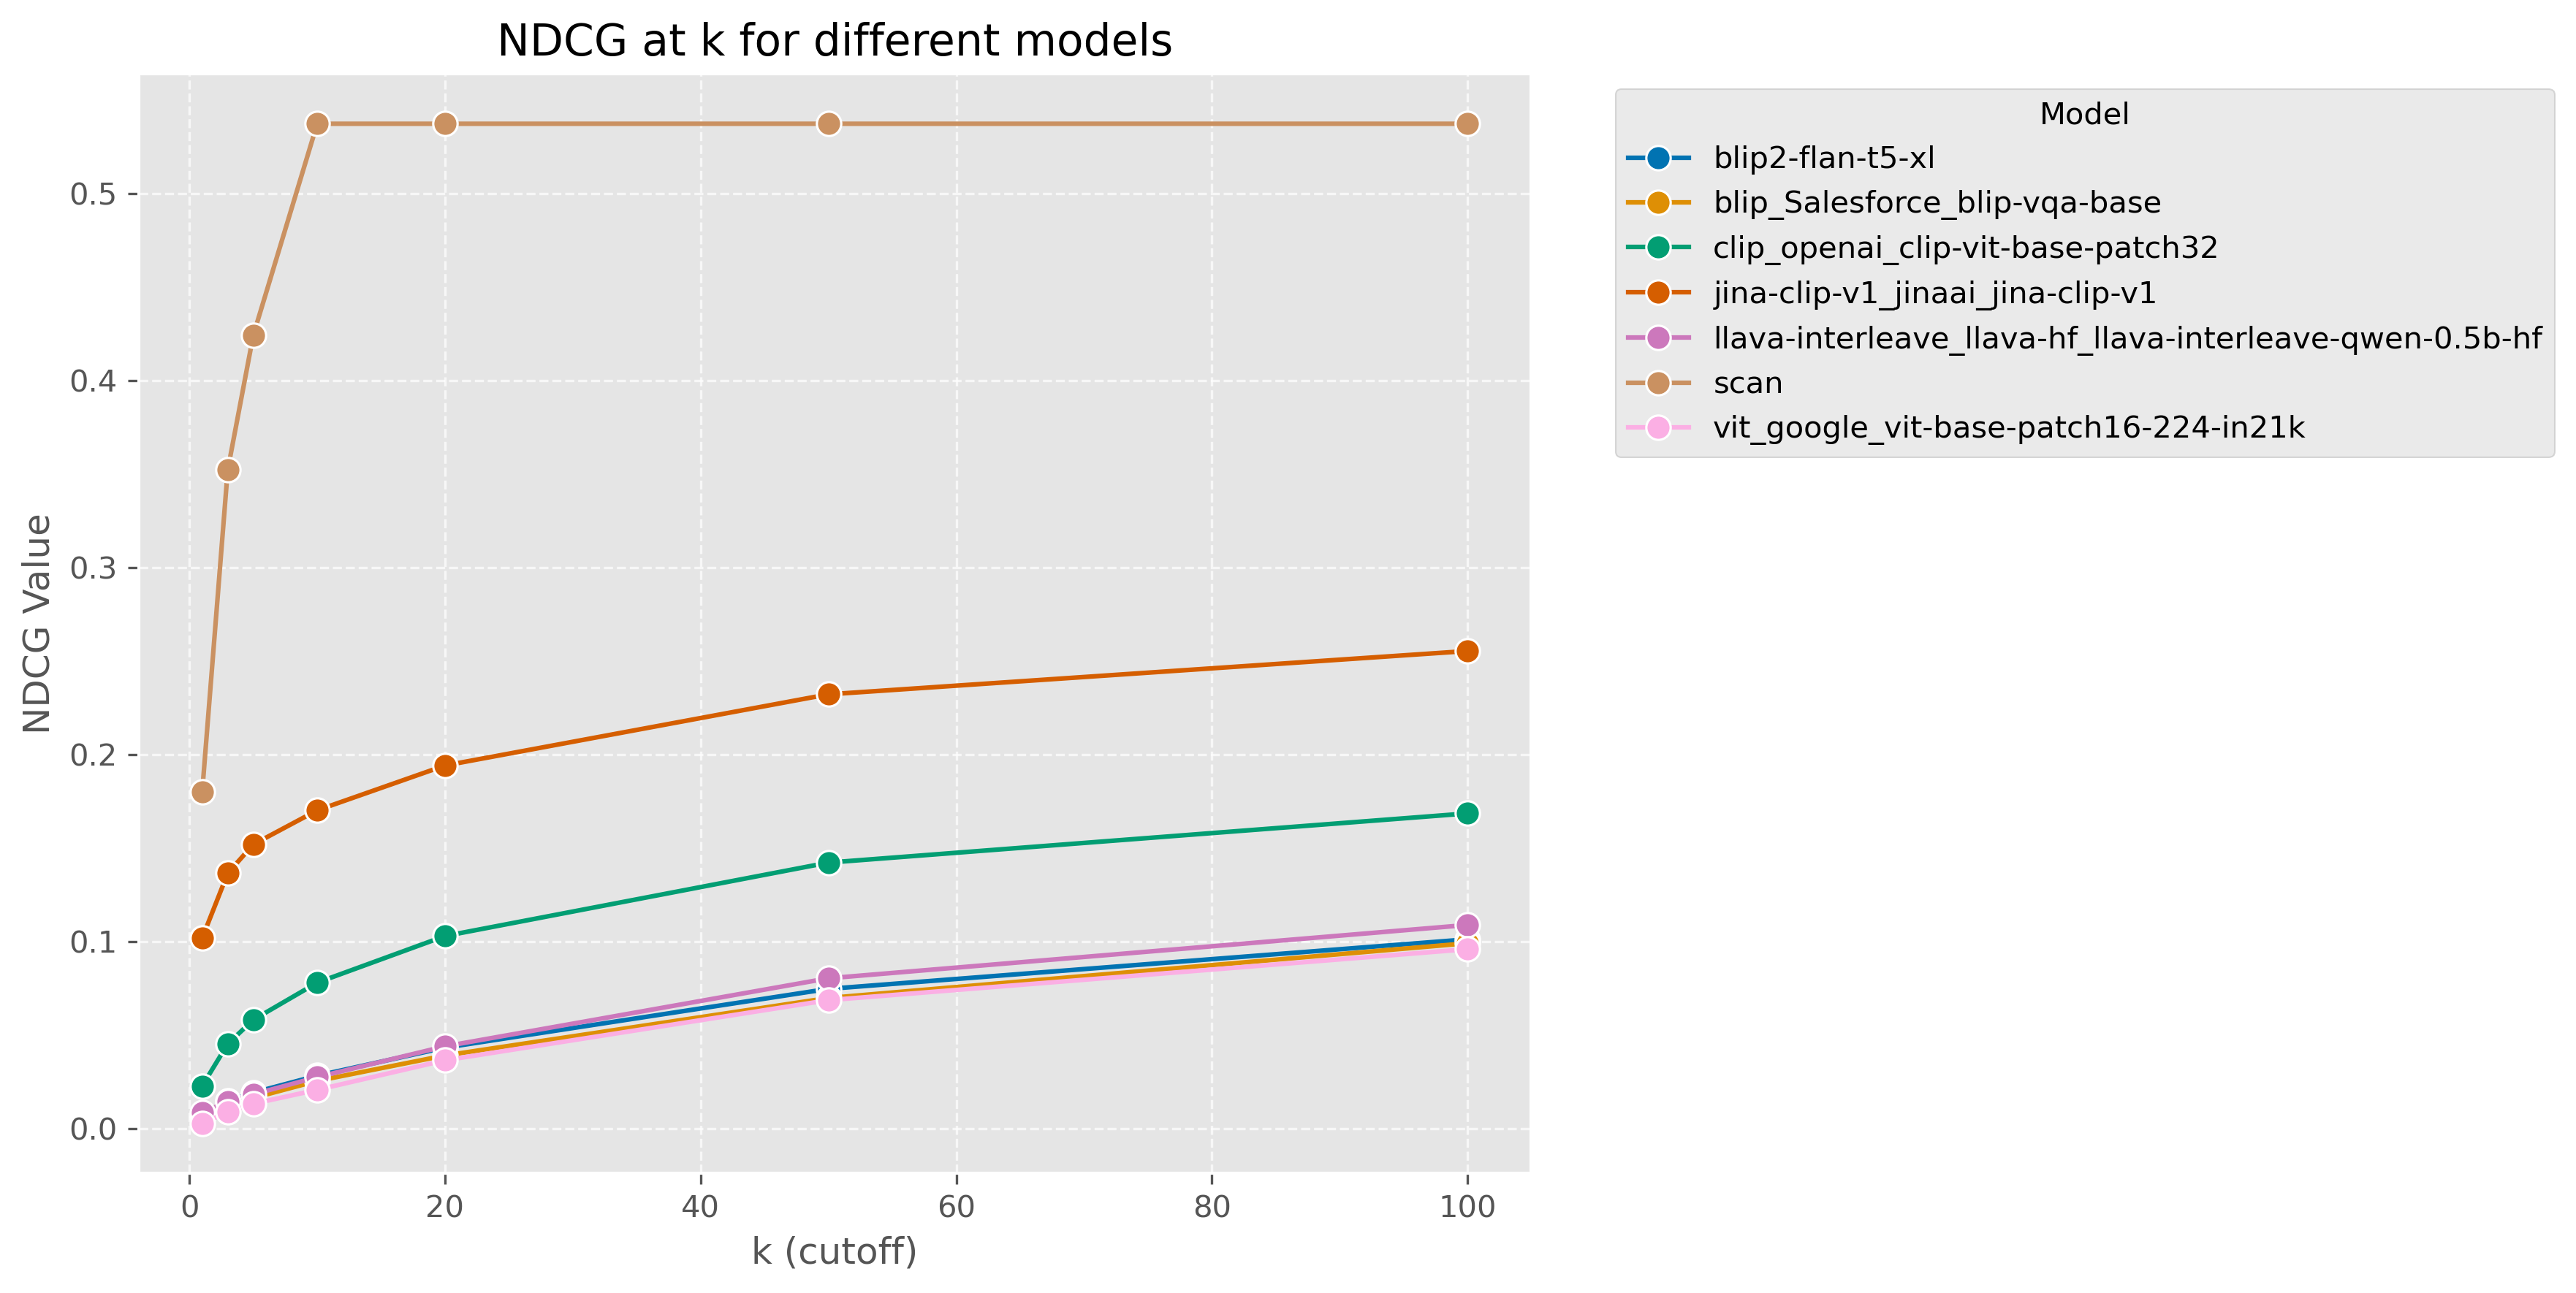

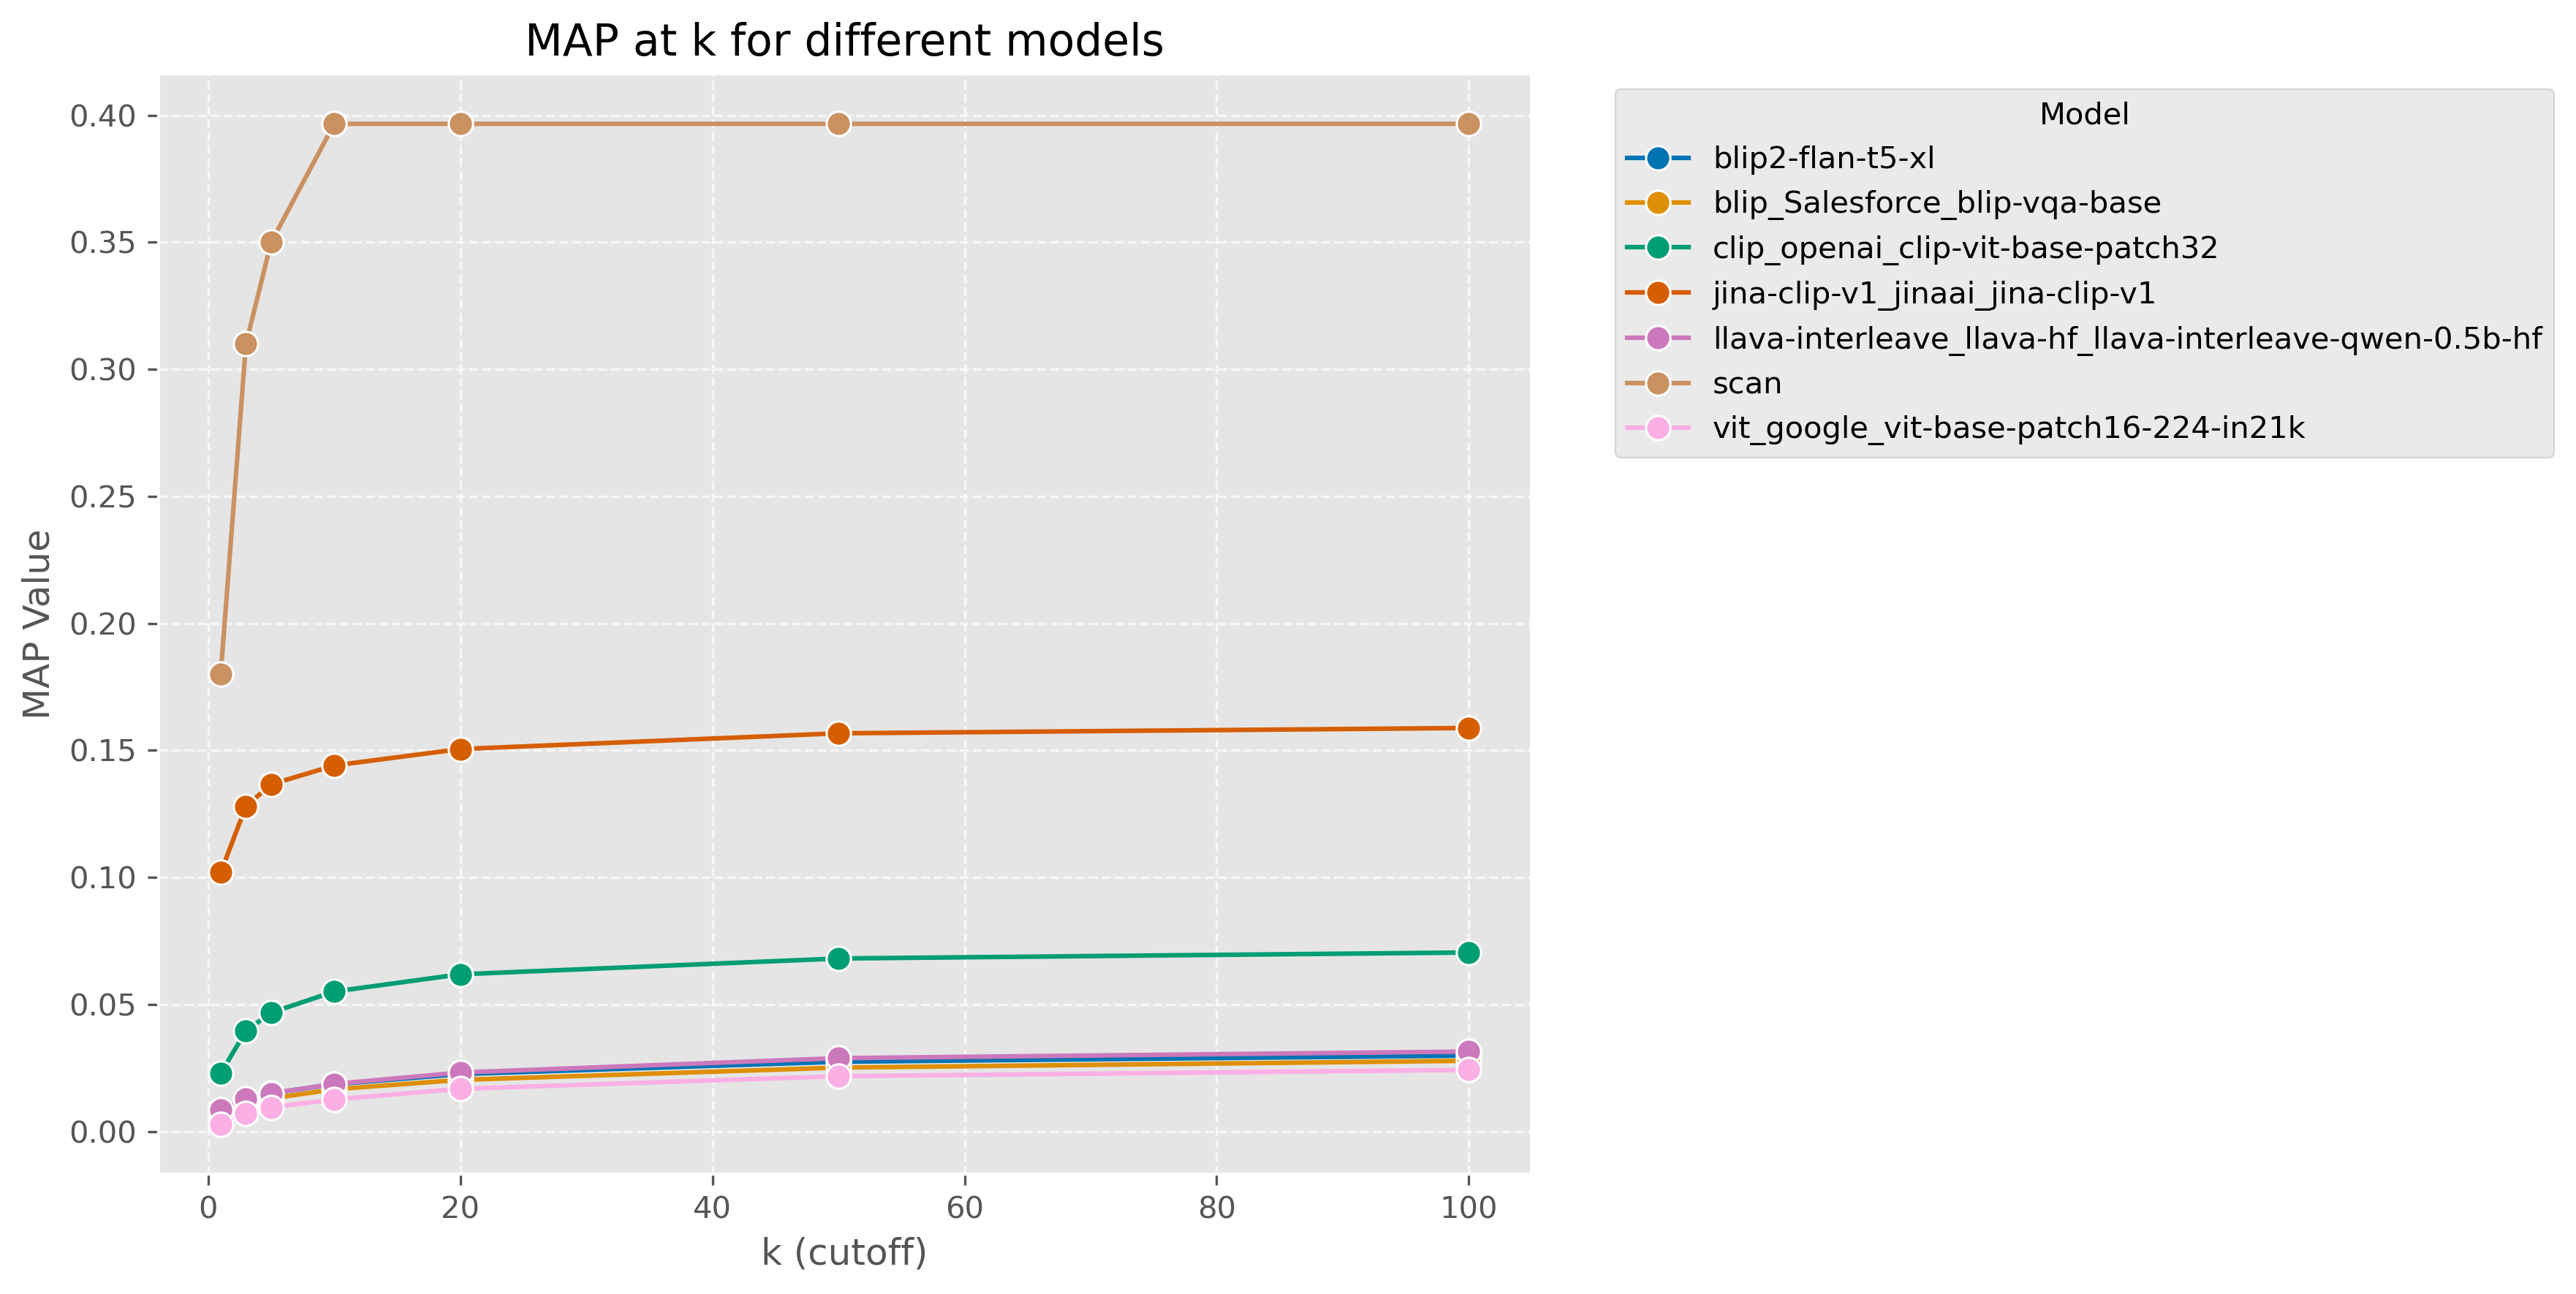

In [20]:
# Plot each metric type
for metric in metric_types:
    plot_metric(metrics_df, metric)

## Compare performance at specific cutoffs

In [21]:
# Function to create a bar chart comparing all models at a specific k value
def compare_at_k(df, k_value):
    plt.figure(figsize=(14, 10), dpi=300)
    
    # Filter for the specific k value
    k_df = df[df['k'] == k_value]
    
    # Create bar chart
    ax = sns.barplot(data=k_df, x='Model', y='Value', hue='Metric')

    plt.title(f'Metrics at k={k_value} for all models')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"./figs/exp1/k={k_value}.png")
    plt.show()

In [22]:
metrics_df = metrics_df[metrics_df['Metric'].isin(['ndcg', 'map'])]

In [23]:
metrics_df

,Model,Metric,k,Value
0,blip2-flan-t5-xl,ndcg,1,0.005753
1,blip2-flan-t5-xl,ndcg,3,0.014965
2,blip2-flan-t5-xl,ndcg,5,0.019325
3,blip2-flan-t5-xl,ndcg,10,0.028397
4,blip2-flan-t5-xl,ndcg,20,0.043377
...,...,...,...,...
205,vit_google_vit-base-patch16-224-in21k,map,5,0.009530
206,vit_google_vit-base-patch16-224-in21k,map,10,0.012647
207,vit_google_vit-base-patch16-224-in21k,map,20,0.016813
208,vit_google_vit-base-patch16-224-in21k,map,50,0.021777


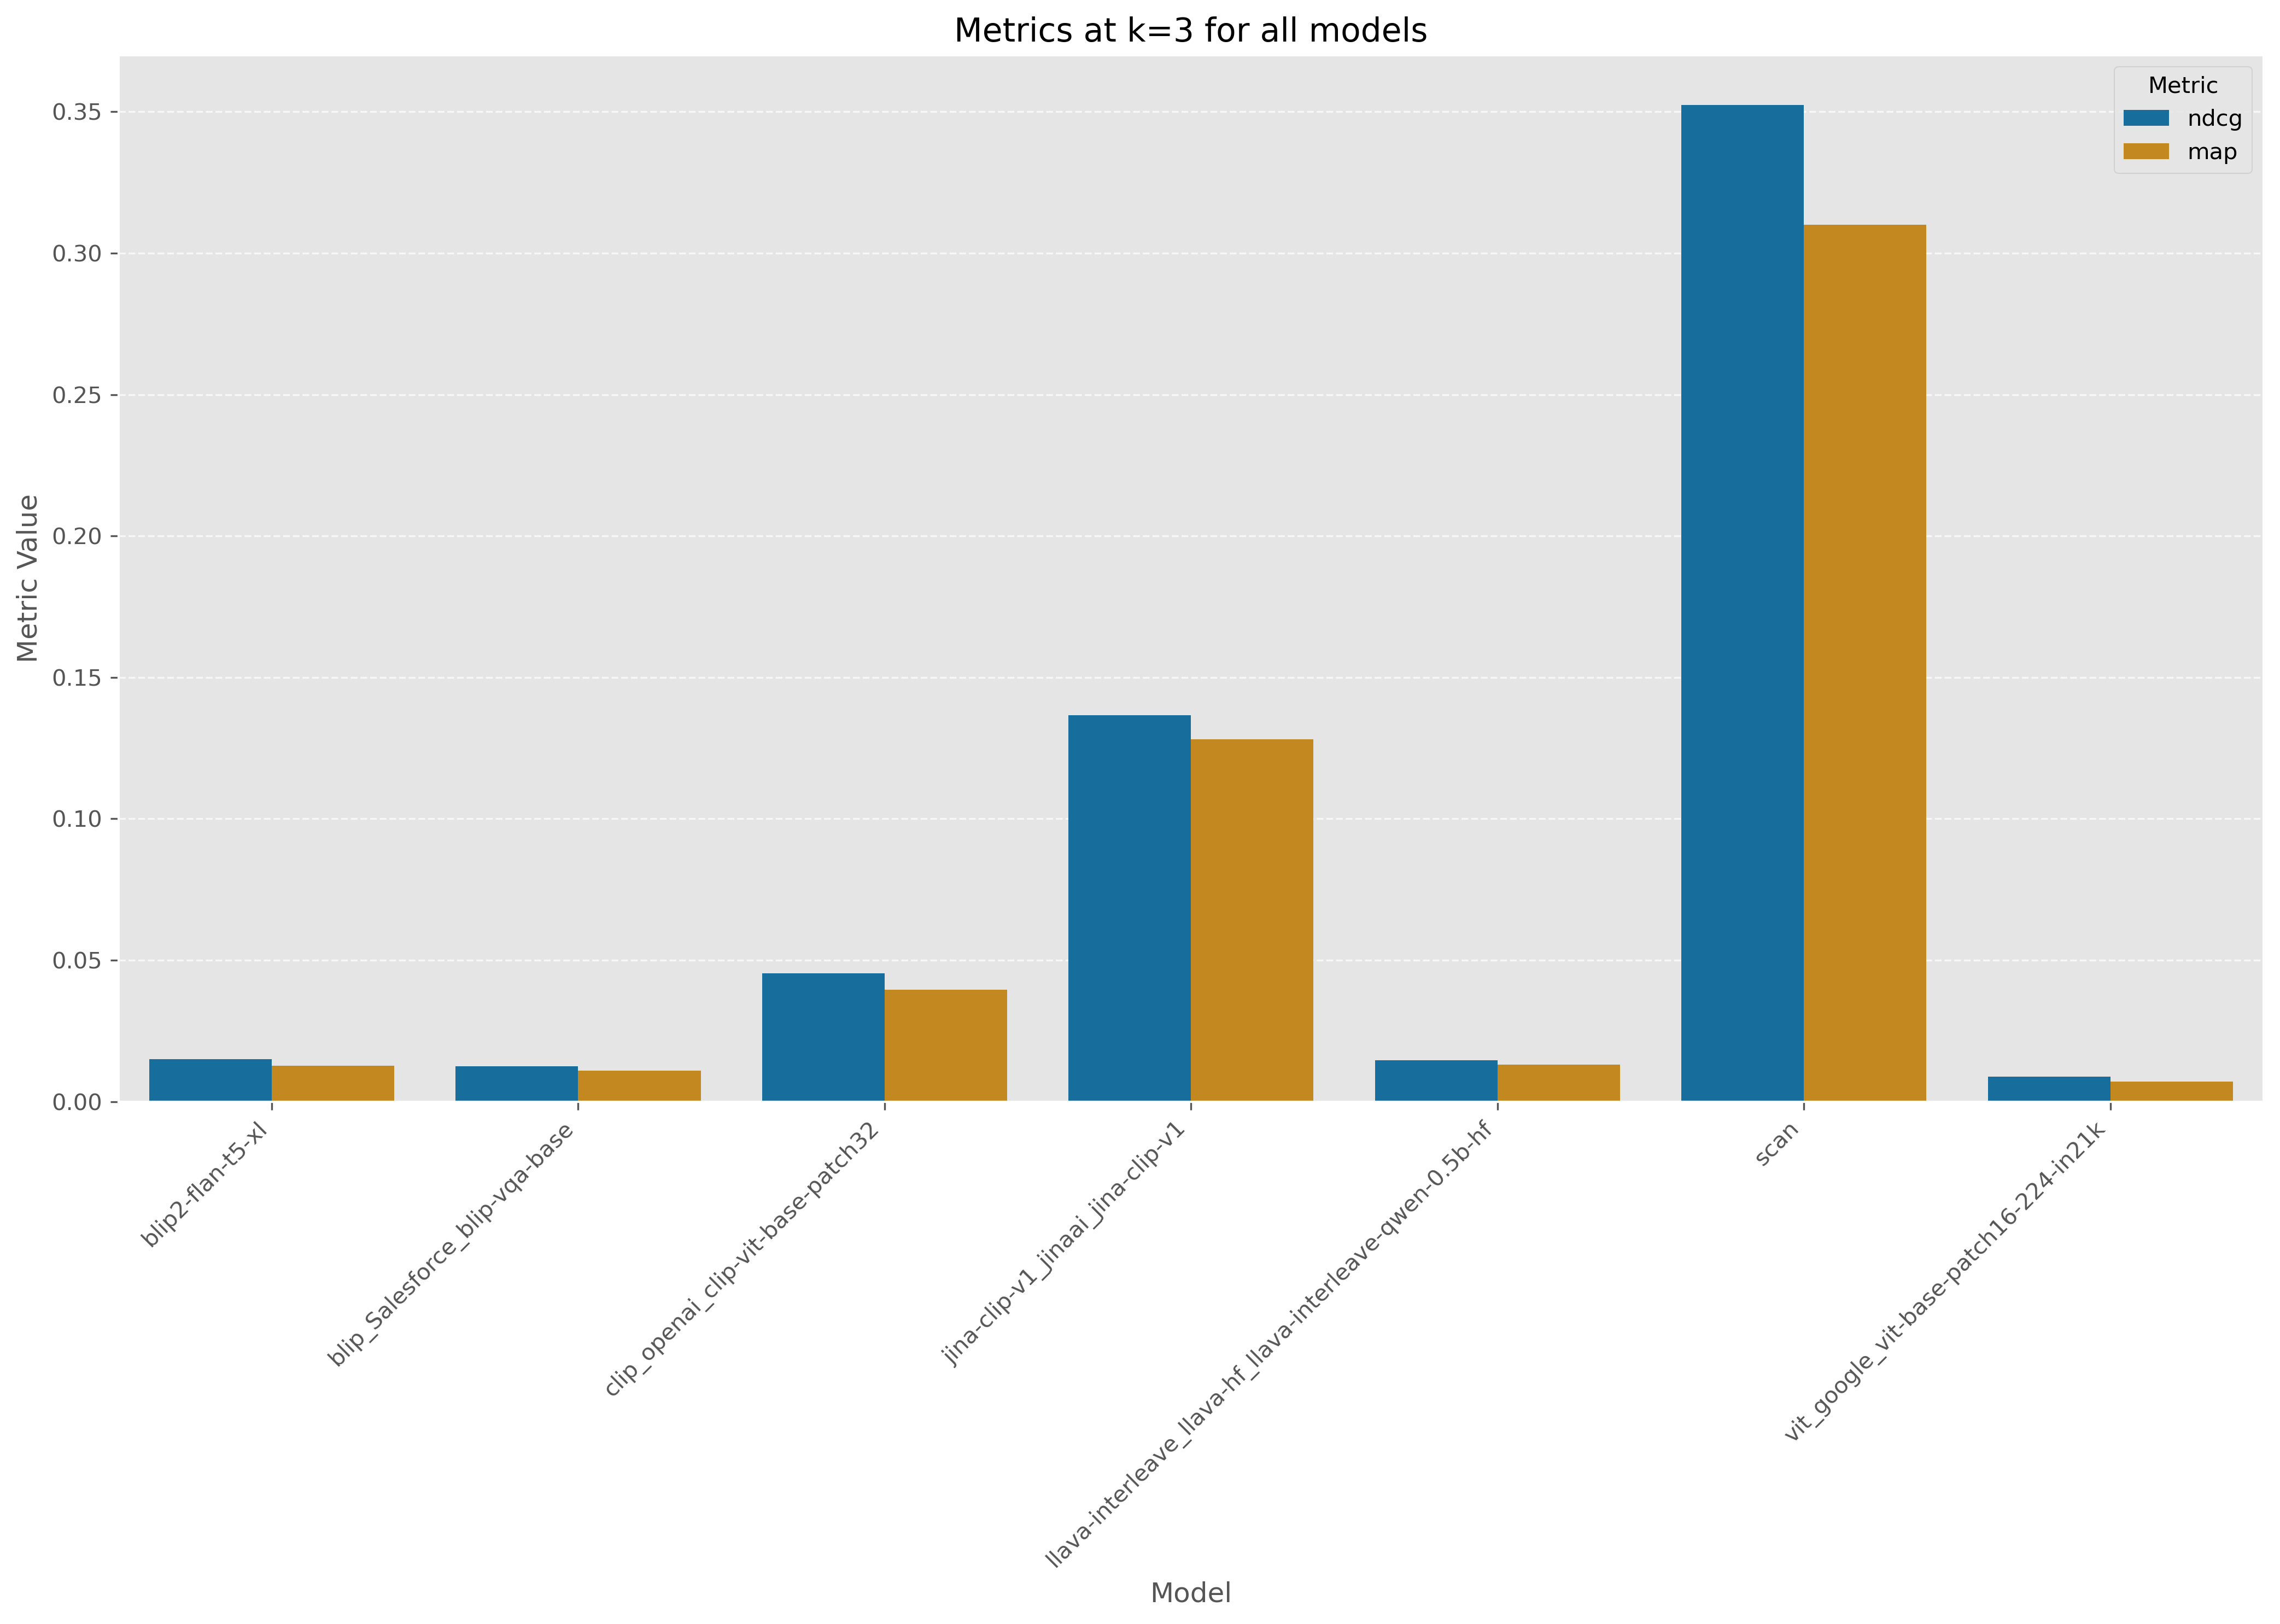

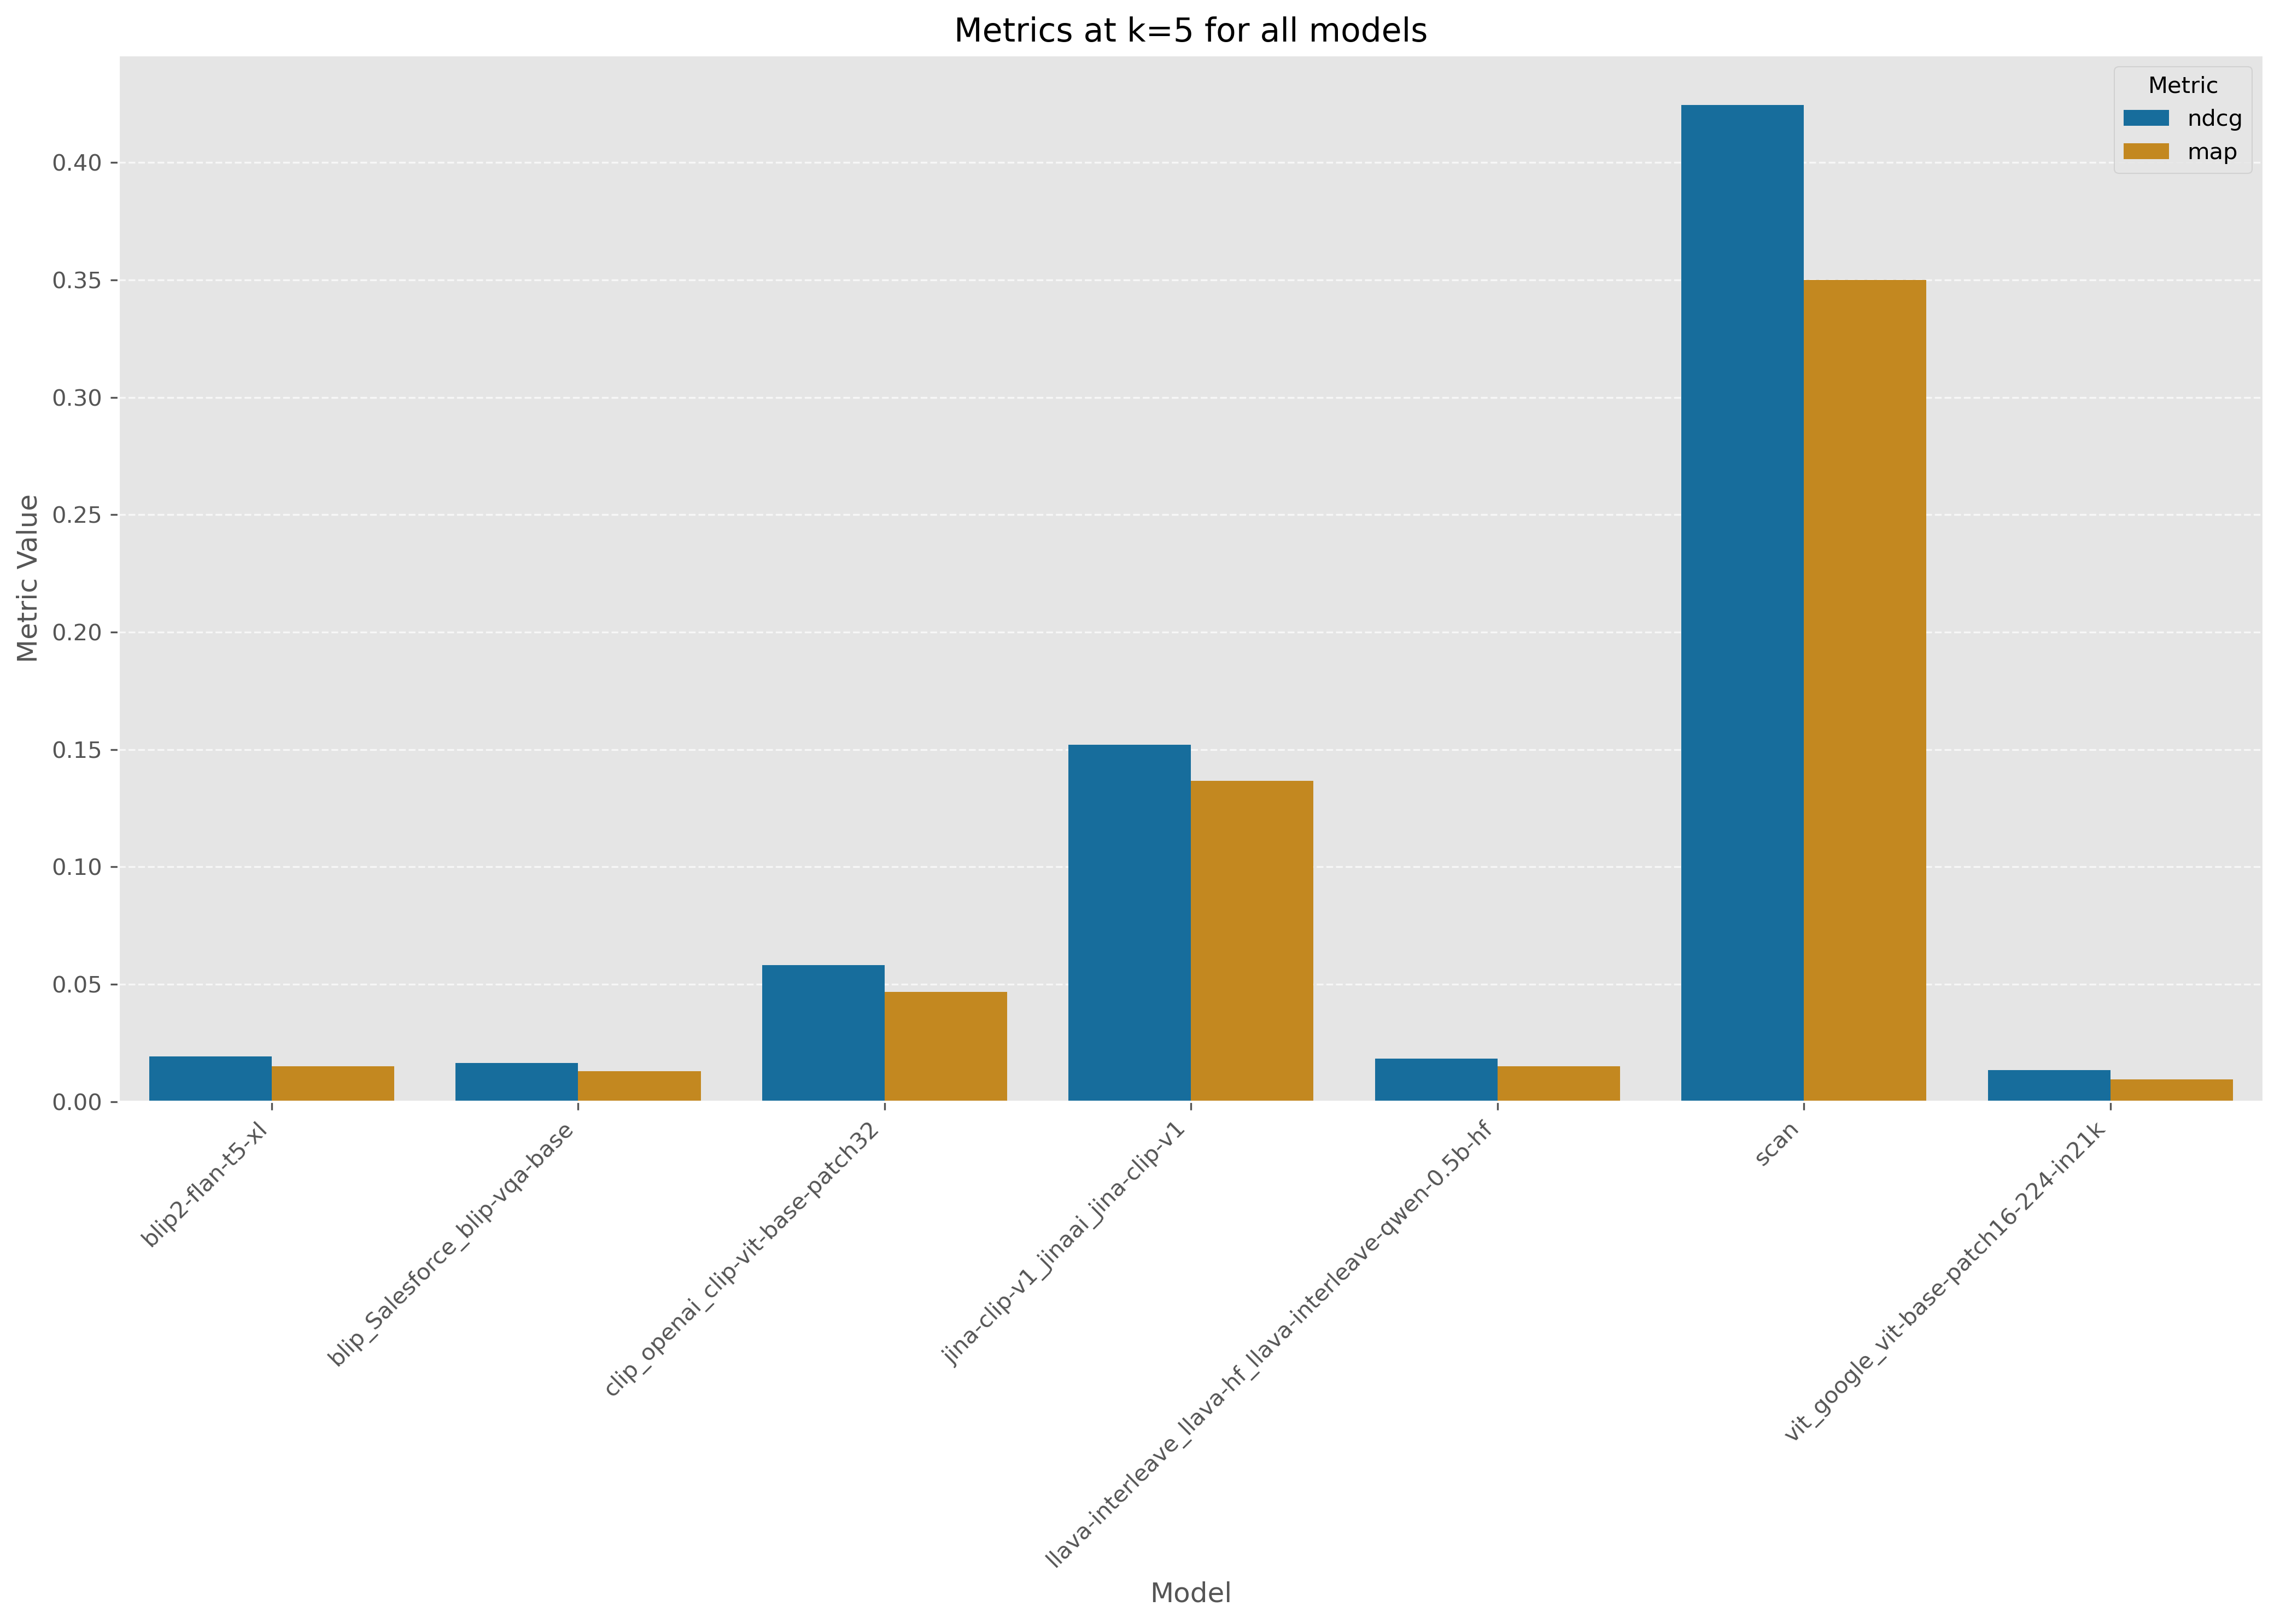

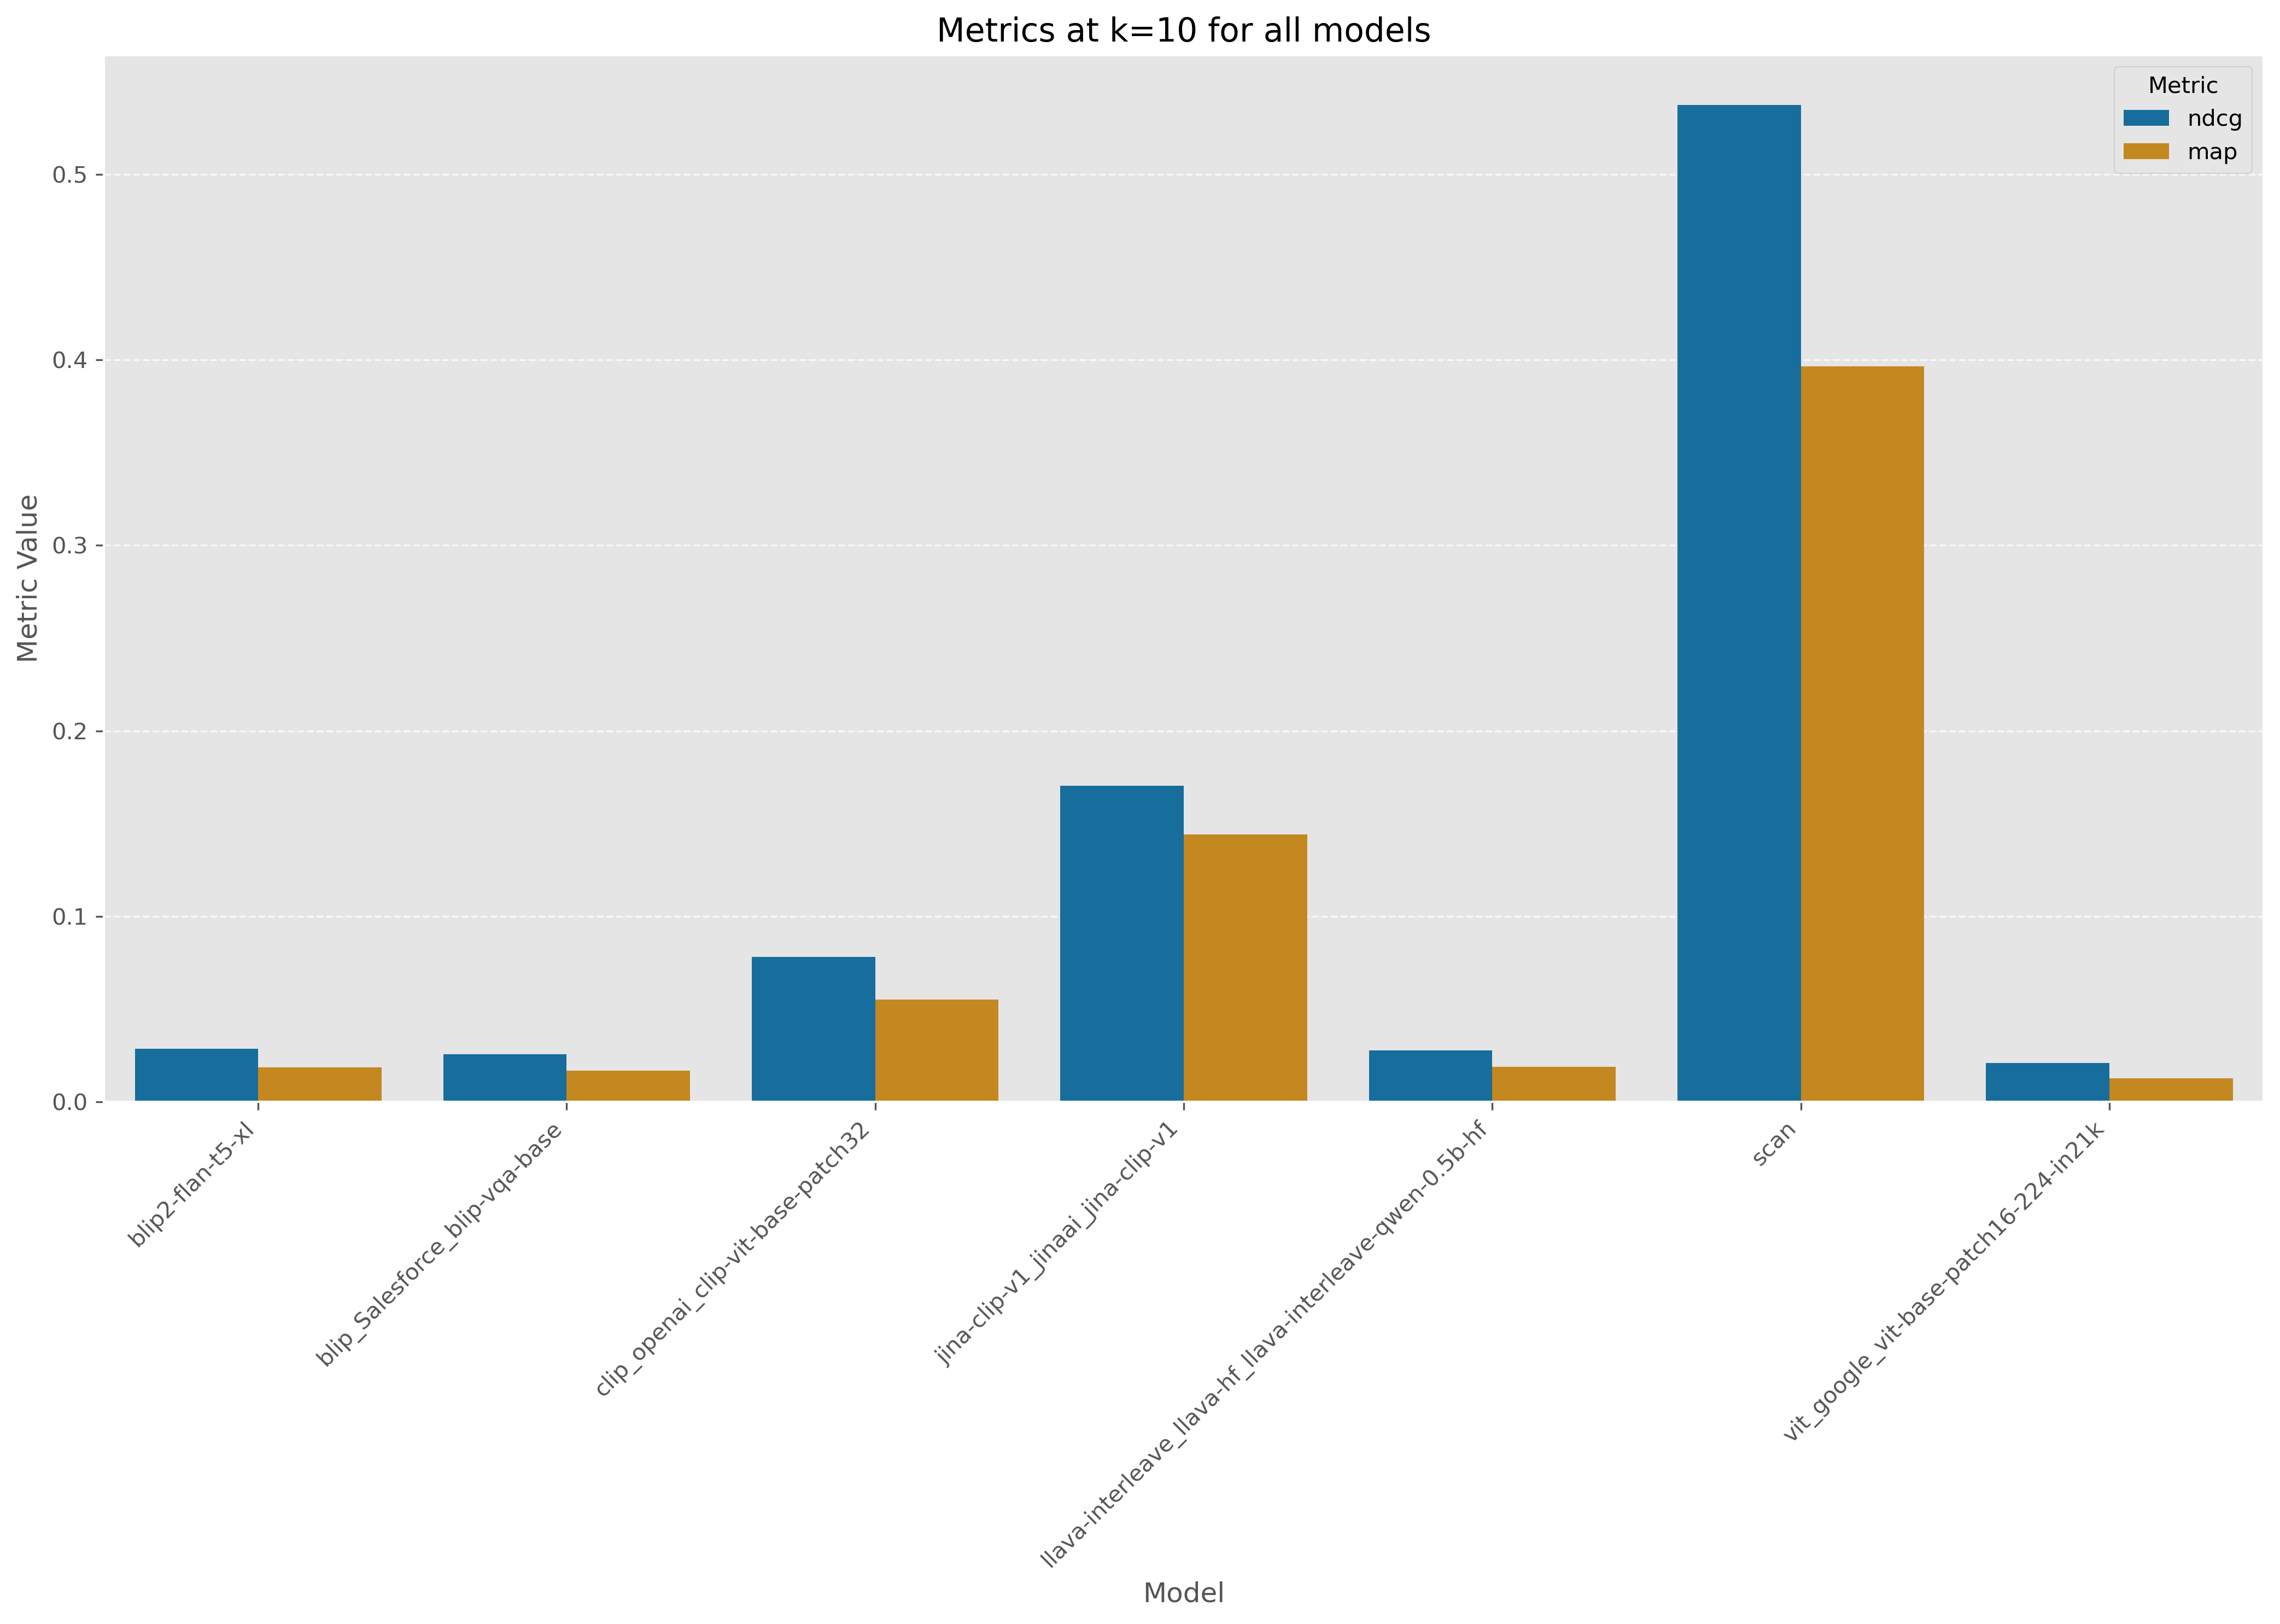

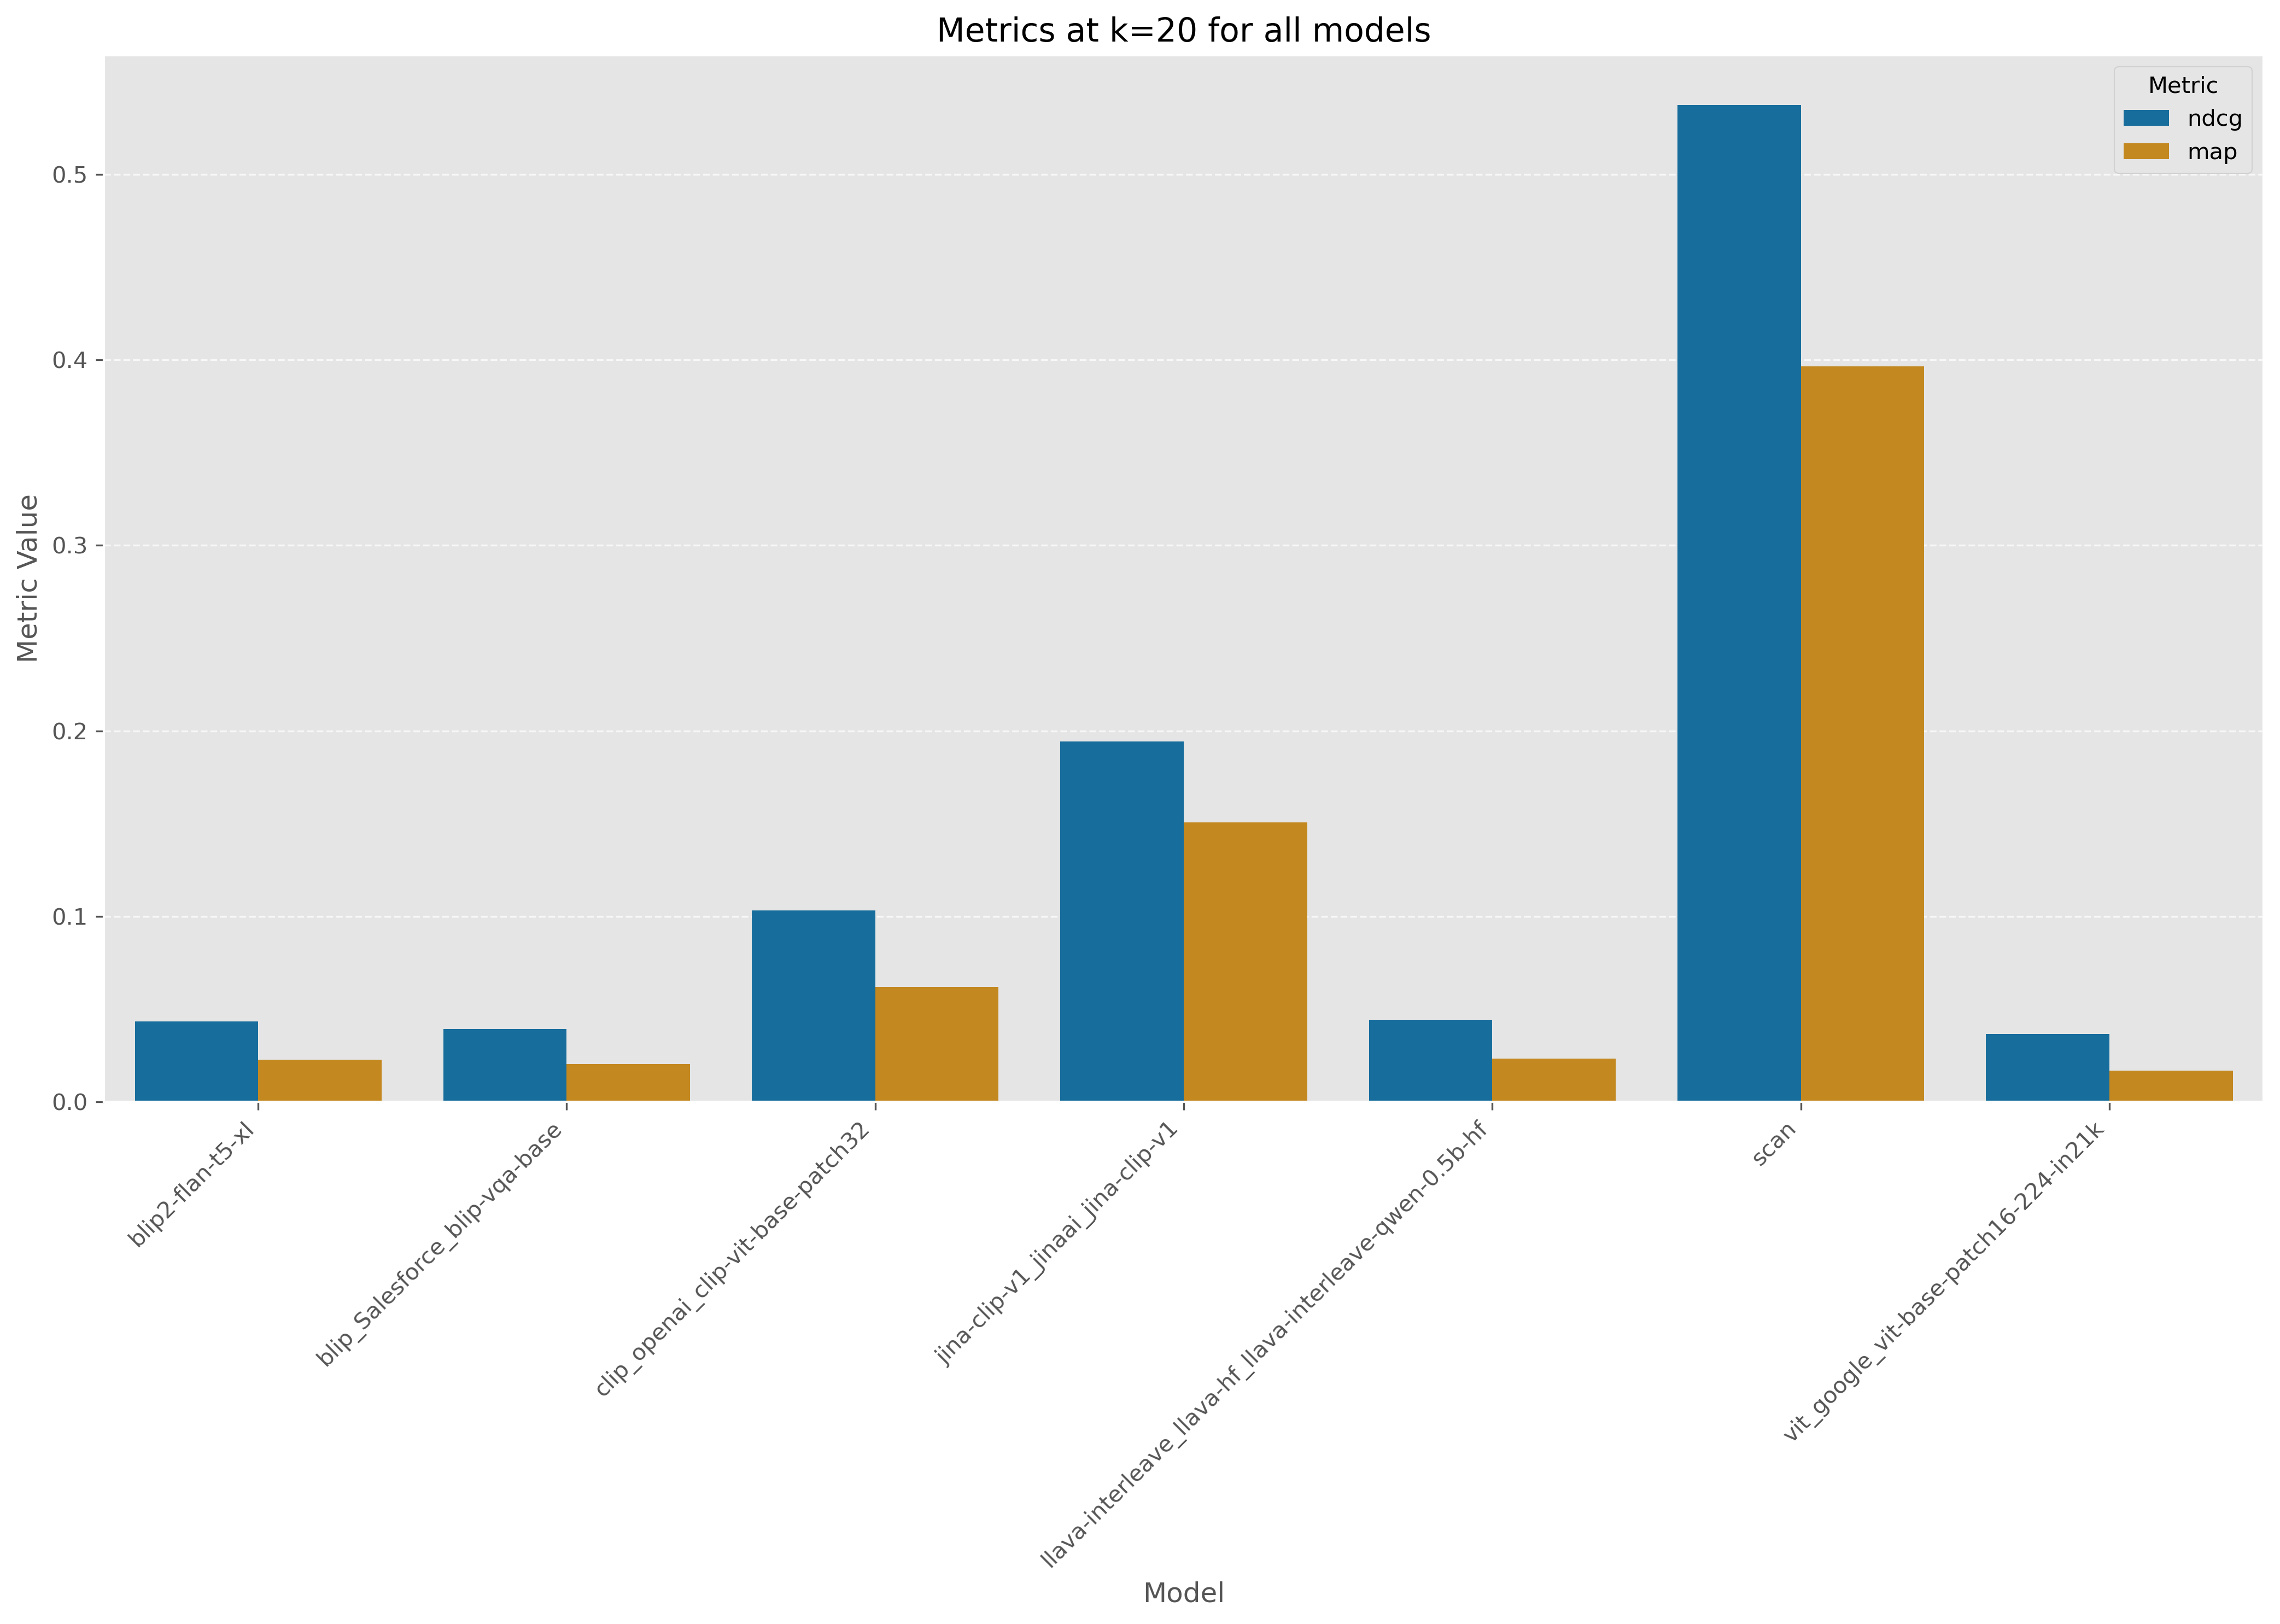

In [24]:
# Compare all metrics at k=5 and k=10
compare_at_k(metrics_df, 3)
compare_at_k(metrics_df, 5)
compare_at_k(metrics_df, 10)
compare_at_k(metrics_df, 20)

## Heatmap comparison of models

In [25]:
# Create a pivot table for each metric type
def create_heatmap(df, metric_name):
    # Filter the dataframe for the specific metric
    filtered_df = df[df['Metric'] == metric_name]
    
    # Create pivot table with models as rows and k values as columns
    pivot_df = filtered_df.pivot(index='Model', columns='k', values='Value')
    
    # Plot heatmap
    plt.figure(figsize=(12, len(pivot_df) * 0.8), dpi=300)
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=.5)
    plt.title(f'{metric_name.upper()} across different k values')
    plt.xlabel('k (cutoff)')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.savefig(f"./figs/exp1/{metric_name}-heatmap.png")
    plt.show()

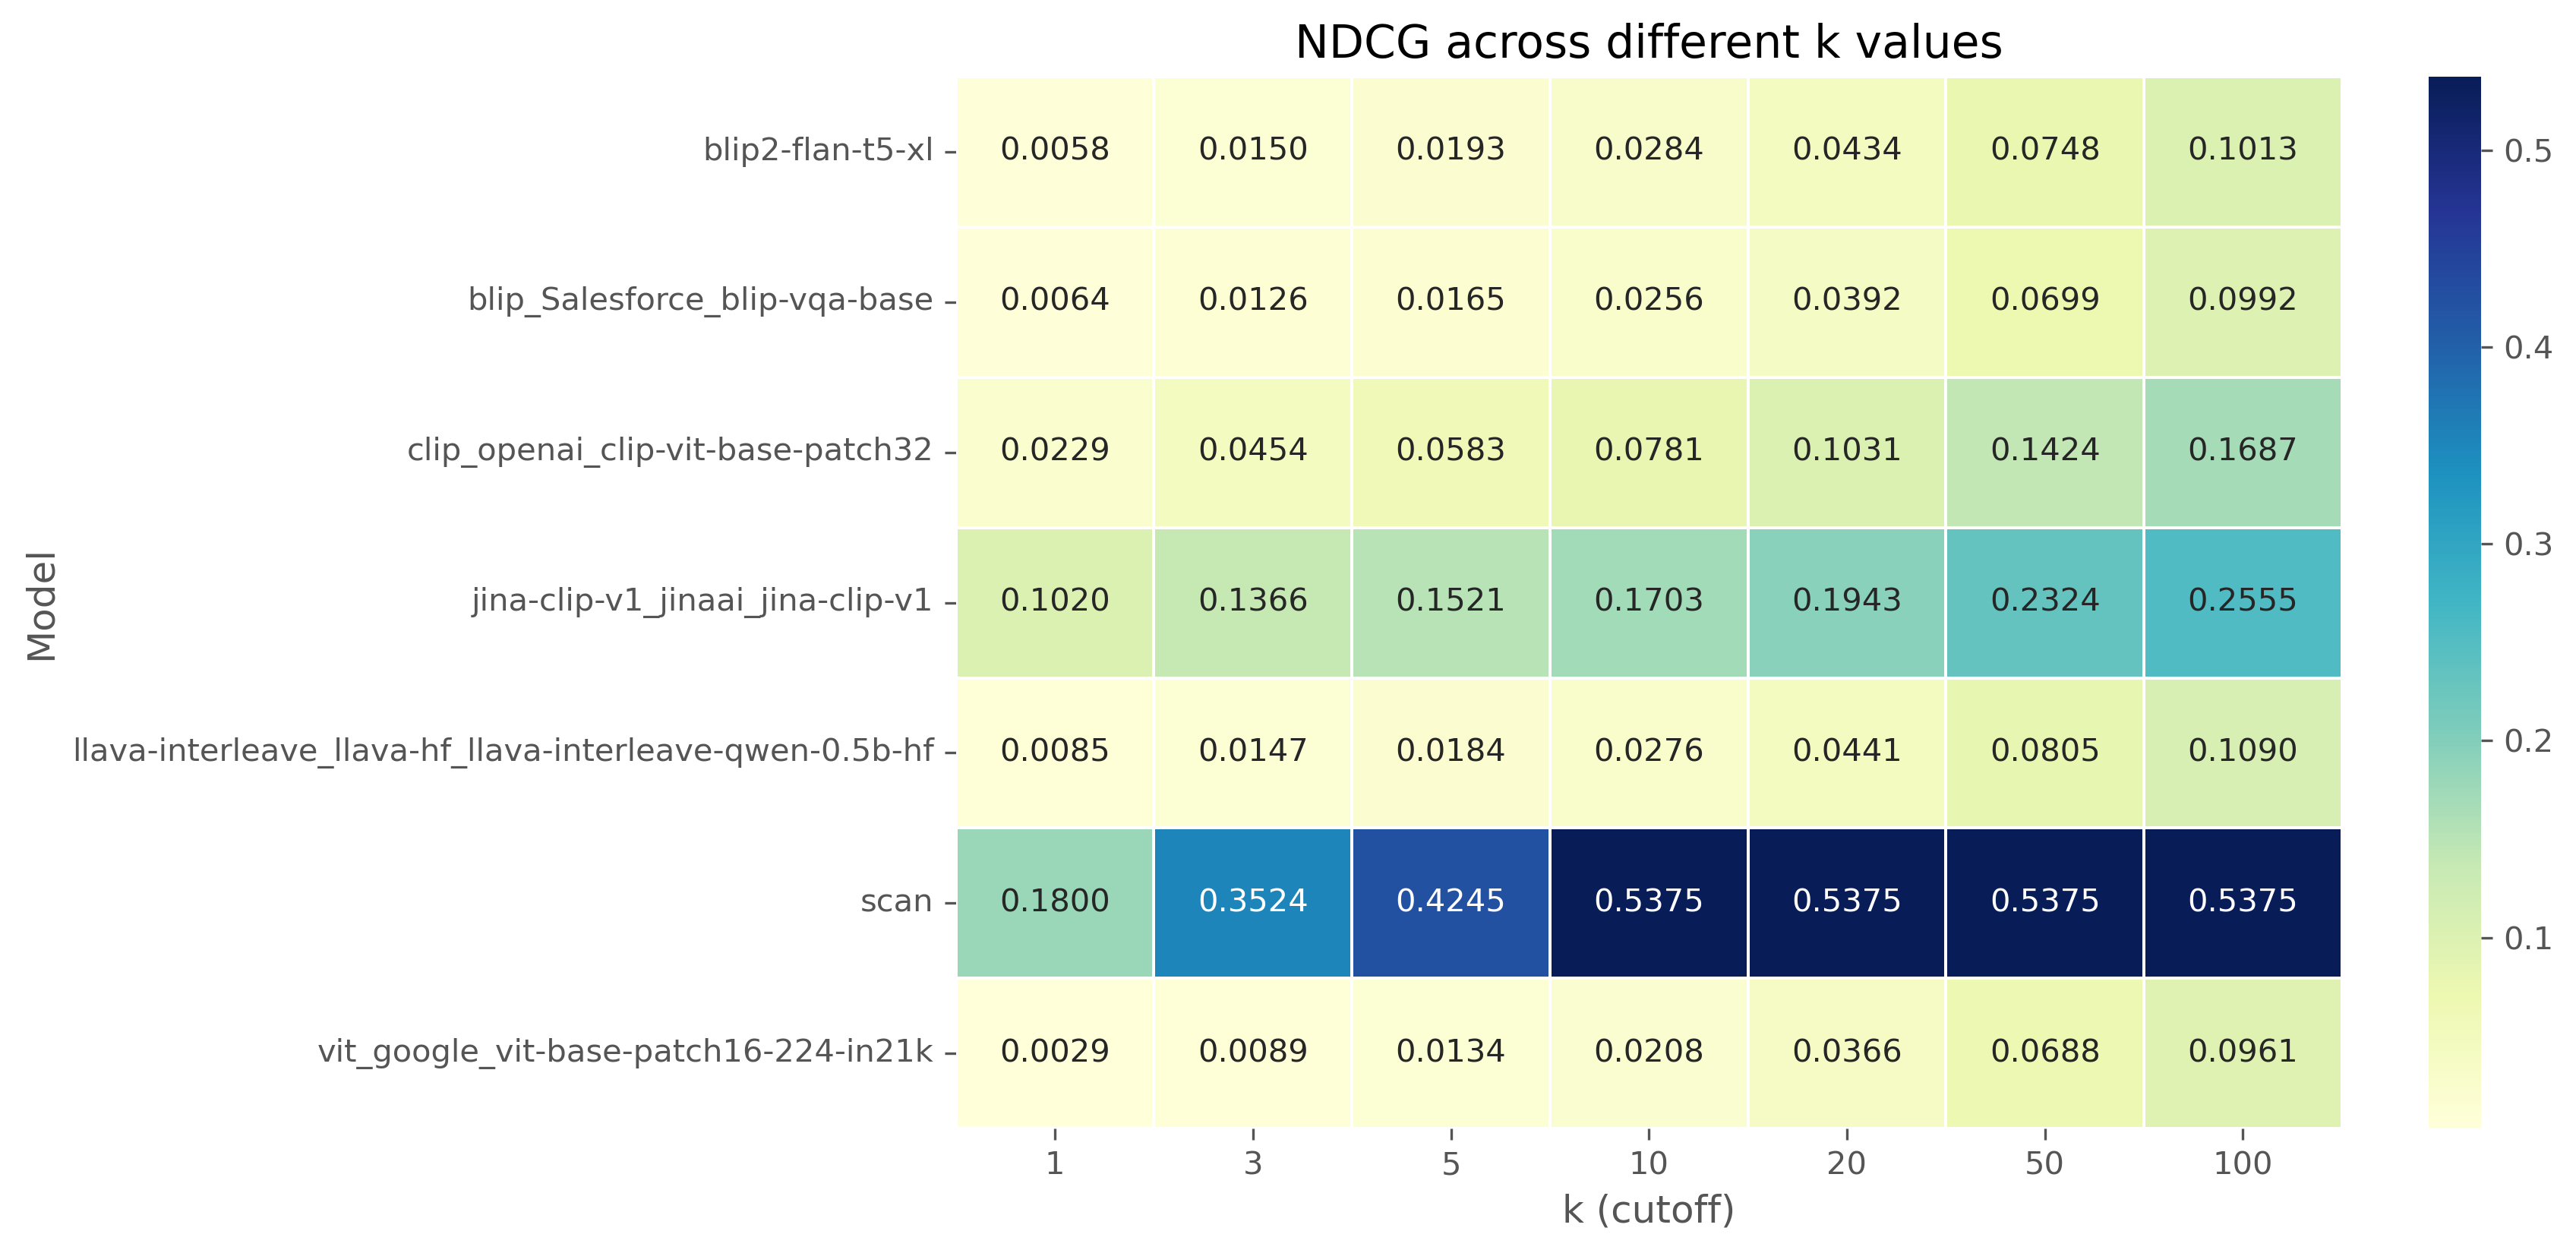

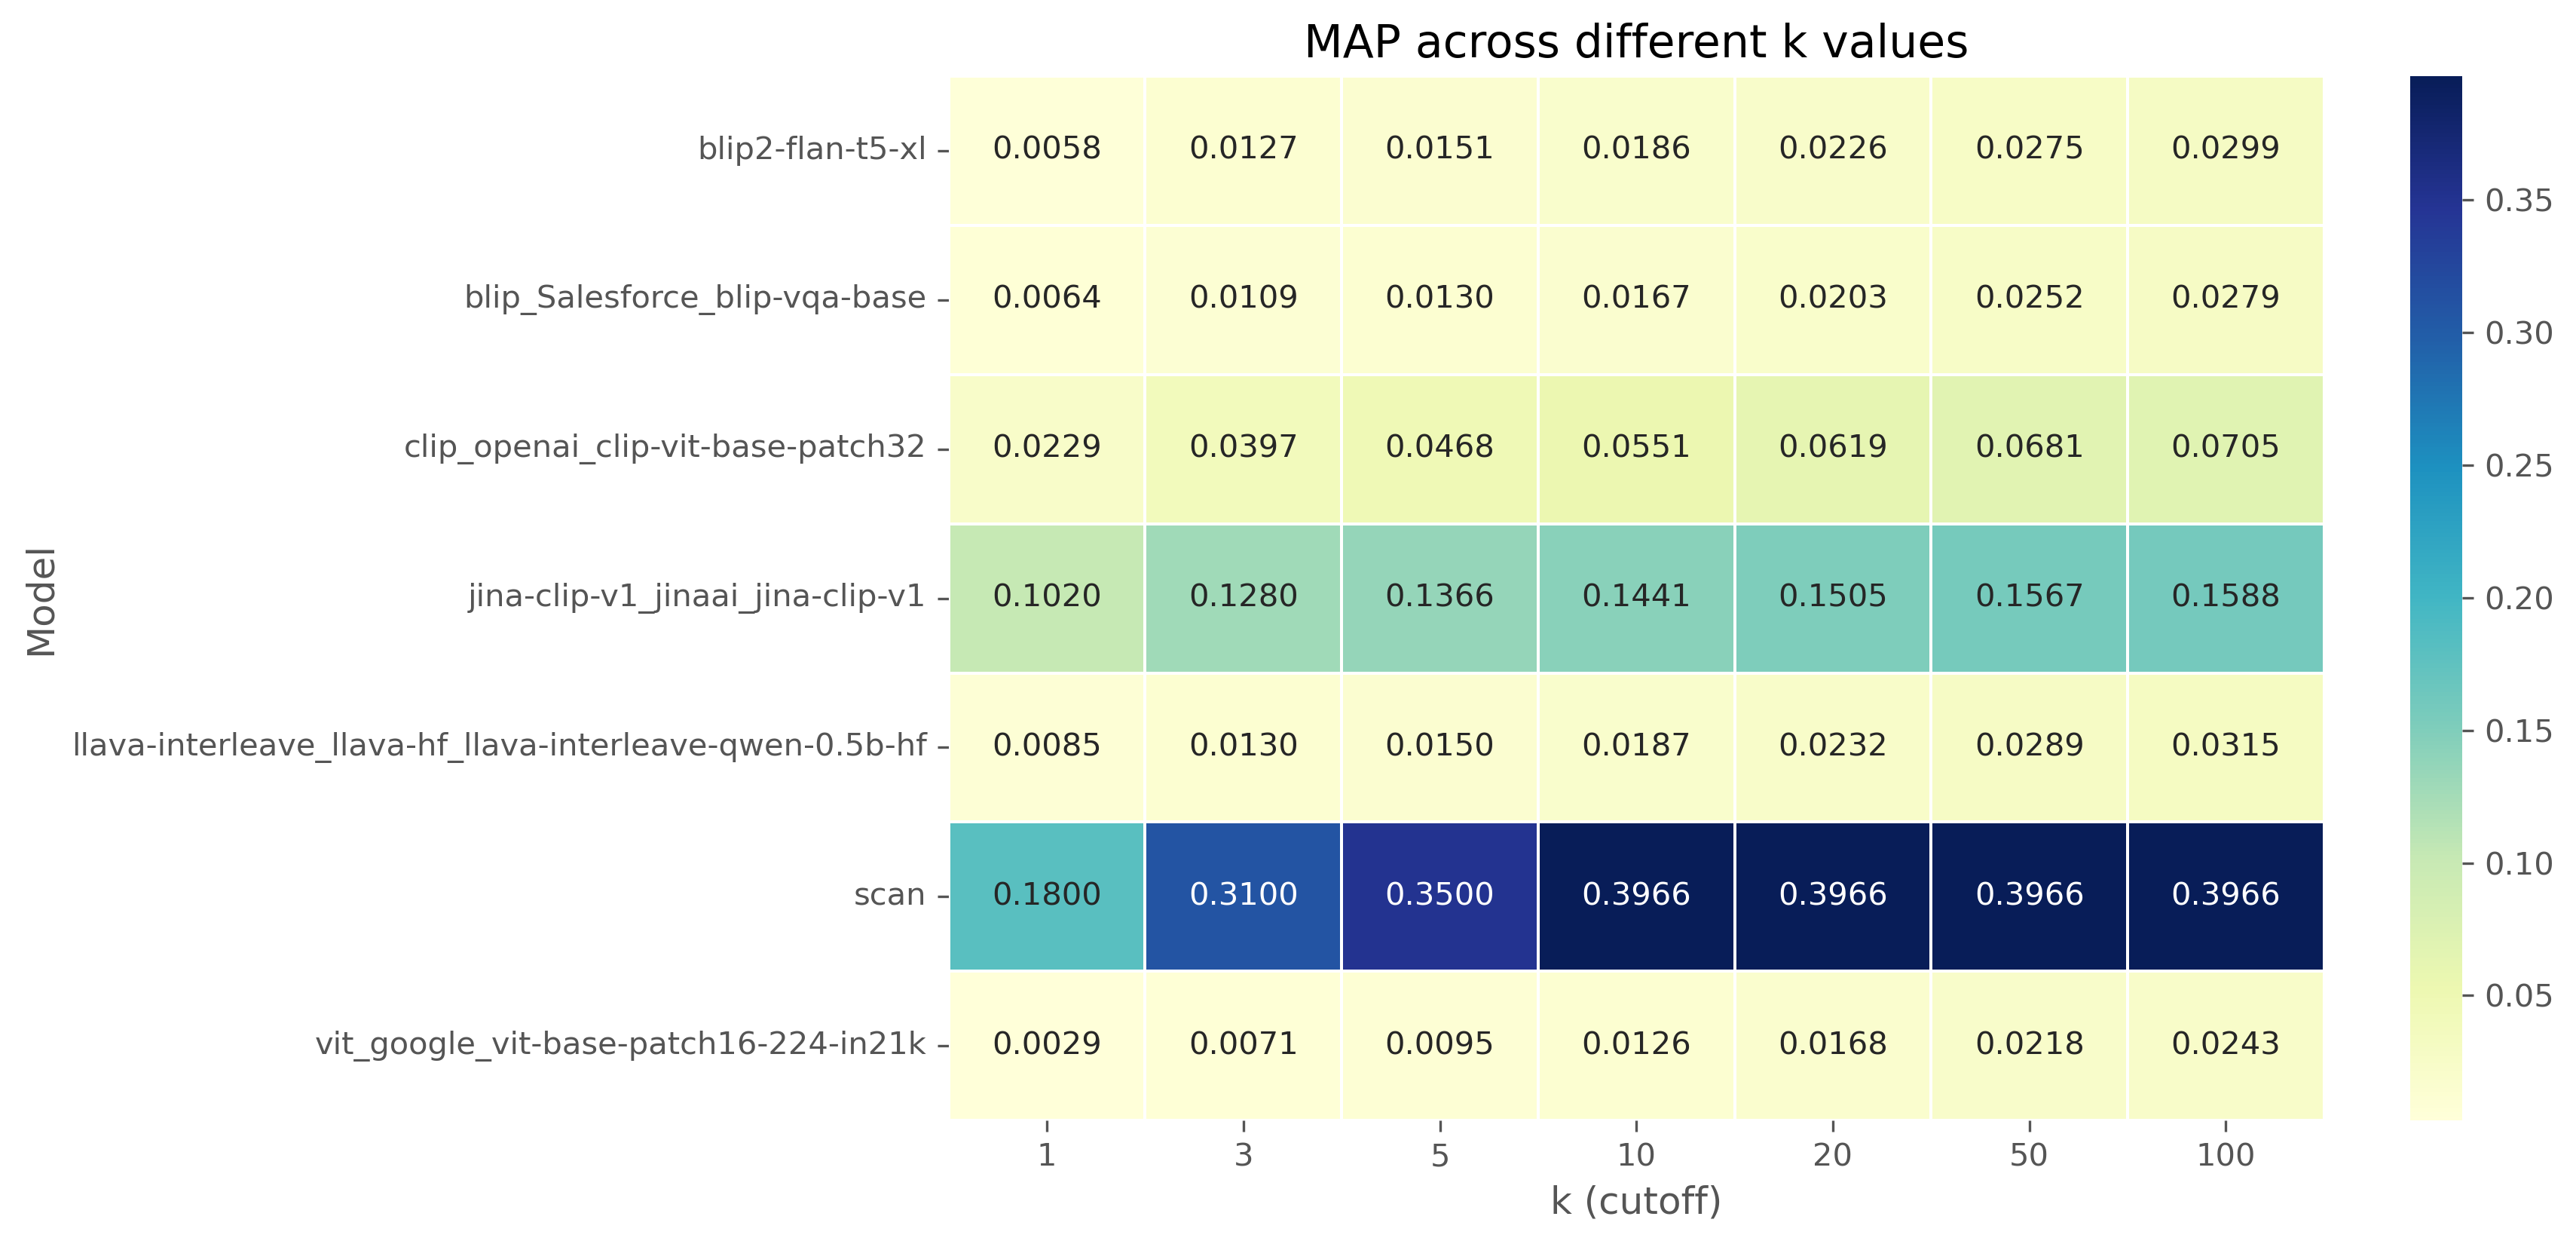

In [26]:
# Create heatmaps for each metric type
for metric in metric_types:
    create_heatmap(metrics_df, metric)

## Performance summary

In [27]:
# Create a summary table of the best performing model for each metric and k value
summary = []

for metric in metric_types:
    for k in k_values:
        filtered = metrics_df[(metrics_df['Metric'] == metric) & (metrics_df['k'] == k)]
        best_model = filtered.loc[filtered['Value'].idxmax()]
        summary.append({
            'Metric': metric,
            'k': k,
            'Best Model': best_model['Model'],
            'Best Value': best_model['Value']
        })

summary_df = pd.DataFrame(summary)
summary_df

,Metric,k,Best Model,Best Value
0,ndcg,1,scan,0.180000
1,ndcg,3,scan,0.352377
2,ndcg,5,scan,0.424459
3,ndcg,10,scan,0.537522
4,ndcg,20,scan,0.537522
5,ndcg,50,scan,0.537522
6,ndcg,100,scan,0.537522
7,map,1,scan,0.180000
8,map,3,scan,0.310001
9,map,5,scan,0.350000


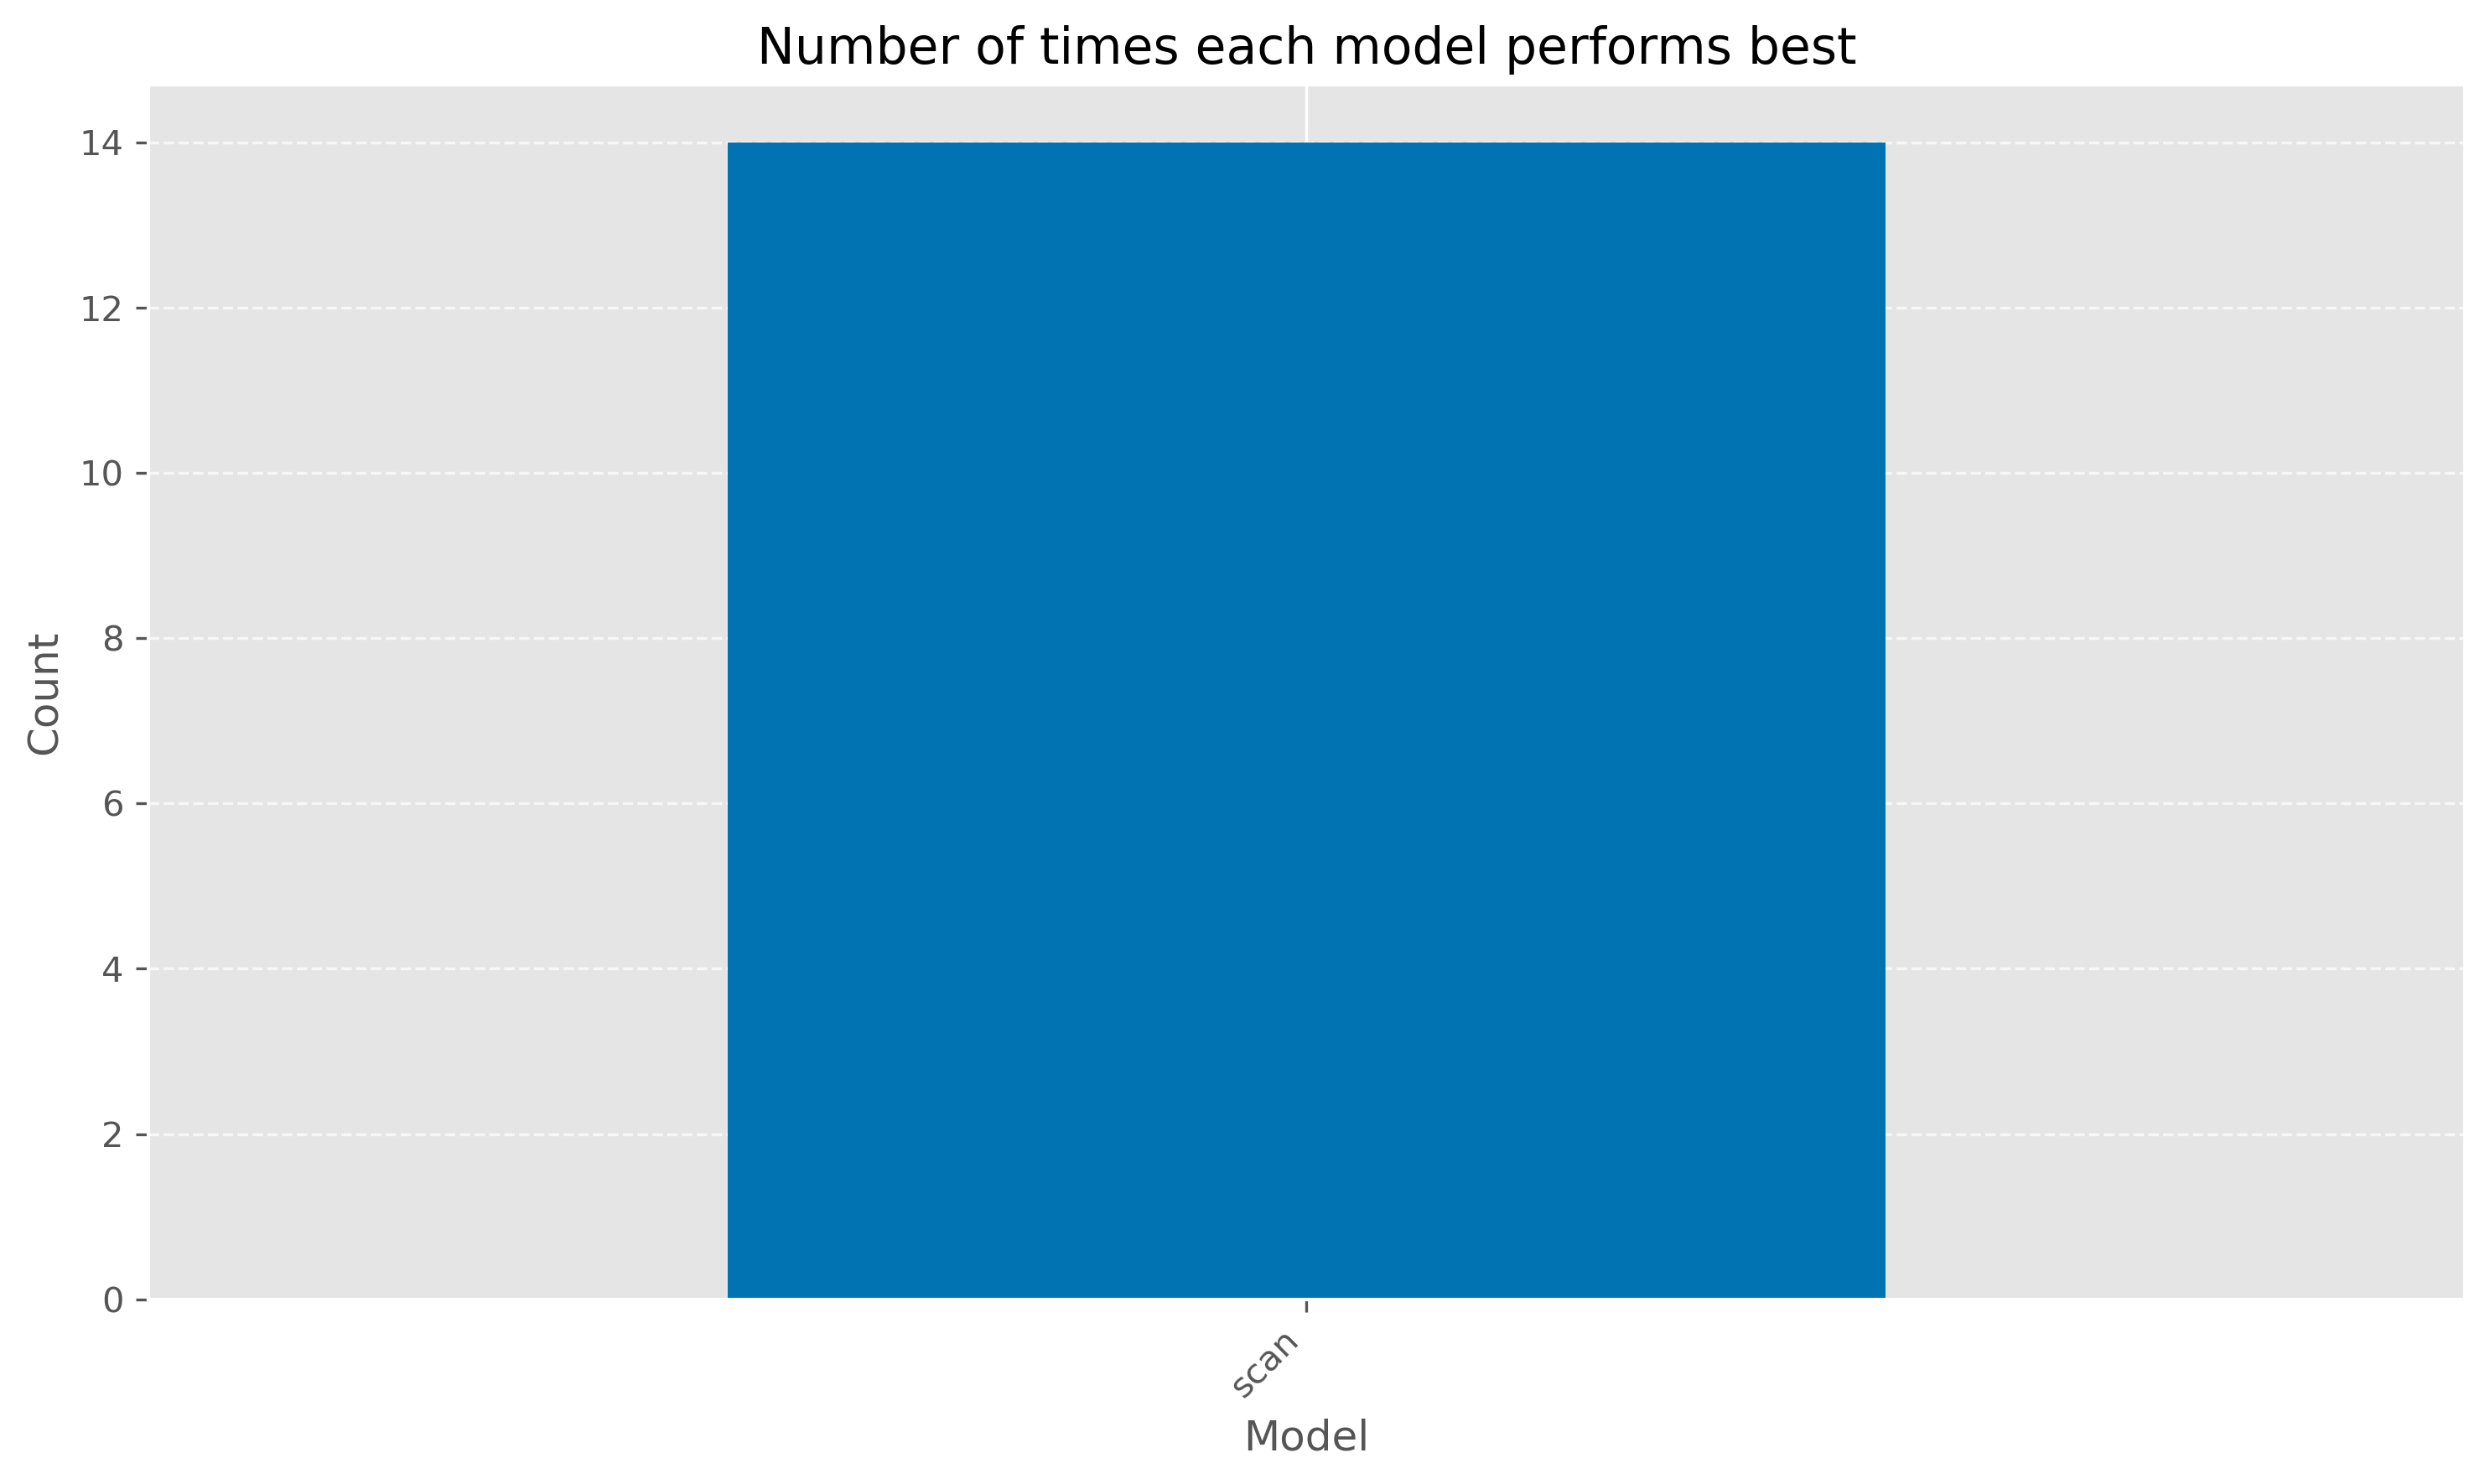

In [28]:
# Count how many times each model is the best
best_model_counts = summary_df['Best Model'].value_counts()

plt.figure(figsize=(10, 6), dpi=300)
best_model_counts.plot(kind='bar')
plt.title('Number of times each model performs best')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comparison of Normal vs. Segmented Image Input

This section compares the performance of models when using normal vs. segmented image input.

In [29]:
# Identify normal and segmented versions of the same model
def extract_base_model_name(model_name):
    # Remove segmentation information to get base model name
    return re.sub(r'_seg_\d+x\d+(?:_overlap_\d+)?$', '', model_name)

# Group models by their base name
model_groups = {}
for model_name in model_metrics.keys():
    base_name = extract_base_model_name(model_name)
    if base_name not in model_groups:
        model_groups[base_name] = []
    model_groups[base_name].append(model_name)

# Filter to keep only models that have both normal and segmented versions
paired_models = {k: v for k, v in model_groups.items() if len(v) > 1}

print("Models with both normal and segmented versions:")
for base_name, variants in paired_models.items():
    pp({base_name: variants})

Models with both normal and segmented versions:


In [30]:
# Function to create a DataFrame comparing normal vs segmented for a specific model
def create_model_comparison_df(base_model_name, model_variants):
    comparison_data = []
    
    for model_variant in model_variants:
        # Determine if this is a normal or segmented variant
        is_segmented = '_seg_' in model_variant
        variant_type = 'Segmented' if is_segmented else 'Normal'
        
        # Get segmentation details if available
        seg_info = ''
        if is_segmented:
            grid_match = re.search(r'_seg_(\d+x\d+)', model_variant)
            overlap_match = re.search(r'_overlap_(\d+)', model_variant)
            
            grid = grid_match.group(1) if grid_match else ''
            overlap = f", {overlap_match.group(1)}% overlap" if overlap_match else ''
            seg_info = f" ({grid}{overlap})"
        
        # Add the variant's metrics to the comparison data
        for metric_type in metric_types:
            for k in k_values:
                metric_key = f"{metric_type}_at_{k}"
                if metric_key in model_metrics[model_variant]:
                    comparison_data.append({
                        'Base Model': base_model_name,
                        'Variant': f"{variant_type}{seg_info}",
                        'Full Name': model_variant,
                        'Metric': metric_type,
                        'k': k,
                        'Value': model_metrics[model_variant][metric_key]
                    })
    
    return pd.DataFrame(comparison_data)

# Create comparison DataFrames for all paired models
model_comparison_dfs = {}
for base_name, variants in paired_models.items():
    model_comparison_dfs[base_name] = create_model_comparison_df(base_name, variants)

In [31]:
# Function to plot comparison of normal vs segmented for a specific model and metric
def plot_normal_vs_segmented(base_model_name, metric_name):
    if base_model_name not in model_comparison_dfs:
        print(f"No comparison data available for {base_model_name}")
        return
        
    df = model_comparison_dfs[base_model_name]
    metric_df = df[df['Metric'] == metric_name]
    
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(data=metric_df, x='k', y='Value', hue='Variant', marker='o', markersize=8)
    
    plt.title(f'{metric_name.upper()} at k for {base_model_name}: Normal vs. Segmented')
    plt.xlabel('k (cutoff)')
    plt.ylabel(f'{metric_name.upper()} Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Input Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [32]:
# # Plot comparison for each paired model and metric
# for base_model_name in paired_models.keys():
#     print(f"\n## {base_model_name} - Normal vs. Segmented Comparison")
#     for metric in metric_types:
#         plot_normal_vs_segmented(base_model_name, metric)

In [33]:
# Function to create a comparison bar chart at a specific k value
def compare_normal_vs_segmented_at_k(base_model_name, k_value):
    if base_model_name not in model_comparison_dfs:
        print(f"No comparison data available for {base_model_name}")
        return
        
    df = model_comparison_dfs[base_model_name]
    k_df = df[df['k'] == k_value]
    
    plt.figure(figsize=(14, 6), dpi=300)
    sns.barplot(data=k_df, x='Metric', y='Value', hue='Variant')
    
    plt.title(f'{base_model_name}: Normal vs. Segmented comparison at k={k_value}')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Input Type')
    plt.tight_layout()
    plt.show()

In [158]:
# # Create bar charts comparing normal vs segmented at k=5 and k=10
# for base_model_name in paired_models.keys():
#     print(f"\n## {base_model_name} - Performance at specific k values")
#     compare_normal_vs_segmented_at_k(base_model_name, 5)
#     compare_normal_vs_segmented_at_k(base_model_name, 10)

In [159]:
# Calculate performance improvement/decline from normal to segmented
improvement_data = []

for base_name, df in model_comparison_dfs.items():
    # Create a pivot table to easily compare normal vs segmented
    pivot = df.pivot_table(index=['Metric', 'k'], columns='Variant', values='Value')
    
    # Get the columns for normal and segmented variants
    normal_col = [col for col in pivot.columns if 'Normal' in col][0] if any('Normal' in col for col in pivot.columns) else None
    segmented_cols = [col for col in pivot.columns if 'Segmented' in col]
    
    if normal_col and segmented_cols:
        for seg_col in segmented_cols:
            # Calculate improvement percentage
            pivot['improvement'] = (pivot[seg_col] - pivot[normal_col]) / pivot[normal_col] * 100
            
            # Add to the improvement data
            for (metric, k), row in pivot.iterrows():
                improvement_data.append({
                    'Base Model': base_name,
                    'Segmentation': seg_col,
                    'Metric': metric,
                    'k': k,
                    'Normal Value': row[normal_col],
                    'Segmented Value': row[seg_col],
                    'Improvement (%)': row['improvement']
                })

improvement_df = pd.DataFrame(improvement_data)
improvement_df.head(10)

""


In [160]:
# Create heatmap showing improvement percentage for each model and metric at k=10
def plot_improvement_heatmap(k_value):
    k_improvement = improvement_df[improvement_df['k'] == k_value]
    
    # Create pivot table for the heatmap
    heatmap_data = k_improvement.pivot_table(index='Base Model', columns='Metric', values='Improvement (%)')
    
    plt.figure(figsize=(12, len(heatmap_data) * 0.8), dpi=300)
    sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", center=0, fmt=".2f", linewidths=.5)
    plt.title(f'Performance improvement (%) from Normal to Segmented at k={k_value}')
    plt.tight_layout()
    plt.show()

In [161]:
plot_improvement_heatmap(1)
plot_improvement_heatmap(3)
plot_improvement_heatmap(5)
plot_improvement_heatmap(10)
plot_improvement_heatmap(20)

KeyError: 'k'